In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.simplefilter(action="ignore", category=Warning)

# 1. Data Cleaning

In [3]:
df = pd.read_csv("cars_data_clean.csv")
df.head()

usedCarSkuId            loc  myear       body  \
0  7111bf25-97af-47f9-867b-40879190d800    gomti nagar   2016  hatchback   
1  c309efc1-efaf-4f82-81ad-dcb38eb36665  borivali west   2015  hatchback   
2  7609f710-0c97-4f00-9a47-9b9284b62d3a         jasola   2015      sedan   
3  278b76e3-5539-4a5e-ae3e-353a2e3b6d7d         jasola   2013  hatchback   
4  b1eab99b-a606-48dd-a75b-57feb8a9ad92  mumbai g.p.o.   2022        muv   

  transmission fuel        km  ip  \
0       manual  cng  69162.00   0   
1       manual  cng  45864.00   0   
2       manual  cng  81506.00   0   
3       manual  cng 115893.00   0   
4       manual  cng  18900.00   0   

                                              images  imgCount  threesixty  \
0  [{'img': 'https://images10.gaadi.com/usedcar_i...        15       False   
1  [{'img': 'https://images10.gaadi.com/usedcar_i...        15       False   
2  [{'img': 'https://images10.gaadi.com/usedcar_i...        15       False   
3                                      [{'img': ''}]         0       False   
4  [{'img': 'https://images10.gaadi.com/usedcar_i...         6       False   

                         dvn     oem           model        variant  \
0     maruti wagon r lxi cng  maruti  maruti wagon r        lxi cng   
1   maruti celerio green vxi  maruti  maruti celerio      green vxi   
2  honda amaze s plus i-vtec   honda     honda amaze  s plus i-vtec   
3     maruti wagon r lxi cng  maruti  maruti wagon r        lxi cng   
4      maruti ertiga vxi cng  maruti   maruti ertiga        vxi cng   

        City  listed_price  discountValue   utype    carType  \
0    lucknow     370000.00              0  dealer  corporate   
1     mumbai     365000.00              0  dealer  corporate   
2  new delhi     421000.00              0  dealer  corporate   
3  new delhi     240000.00              0  dealer  corporate   
4     mumbai    1175000.00              0  dealer    partner   

                                        top_features  \
0  ['power steering', 'power windows front', 'air...   
1  ['power steering', 'power windows front', 'air...   
2  ['power steering', 'power windows front', 'air...   
3  ['power steering', 'power windows front', 'air...   
4  ['power steering', 'power windows front', 'air...   

                                    comfort_features  \
0  ['power steering', 'power windows front', 'rem...   
1  ['power steering', 'power windows front', 'pow...   
2  ['power steering', 'power windows front', 'pow...   
3  ['power steering', 'power windows front', 'low...   
4  ['power steering', 'power windows front', 'pow...   

                                   interior_features  \
0  ['air conditioner', 'heater', 'digital odomete...   
1  ['air conditioner', 'heater', 'digital odomete...   
2  ['air conditioner', 'heater', 'adjustable stee...   
3  ['air conditioner', 'heater', 'electronic mult...   
4  ['air conditioner', 'heater', 'adjustable stee...   

                                   exterior_features  \
0  ['adjustable head lights', 'manually adjustabl...   
1  ['adjustable head lights', 'manually adjustabl...   
2  ['adjustable head lights', 'power adjustable e...   
3  ['adjustable head lights', 'manually adjustabl...   
4  ['adjustable head lights', 'power adjustable e...   

                                     safety_features   Color  \
0  ['centeral locking', 'child safety locks', 'da...  silver   
1  ['centeral locking', 'child safety locks', 'da...    grey   
2  ['centeral locking', 'power door locks', 'chil...  silver   
3  ['centeral locking', 'child safety locks', 'da...  silver   
4  ['anti lock braking system', 'brake assist', '...   white   

              Engine Type  No of Cylinder  Valves per Cylinder  \
0             k10b engine            3.00                 4.00   
1             k10b engine            3.00                 4.00   
2    i-vtec petrol engine            4.00                 4.00   
3  k series petrol engine            3.00                 4.00   
4  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37813 entries, 0 to 37812
Data columns (total 66 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   usedCarSkuId              37813 non-null  object 
 1   loc                       31963 non-null  object 
 2   myear                     37813 non-null  int64  
 3   body                      37794 non-null  object 
 4   transmission              37813 non-null  object 
 5   fuel                      37813 non-null  object 
 6   km                        37813 non-null  float64
 7   ip                        37813 non-null  int64  
 8   images                    37813 non-null  object 
 9   imgCount                  37813 non-null  int64  
 10  threesixty                37813 non-null  bool   
 11  dvn                       37813 non-null  object 
 12  oem                       37813 non-null  object 
 13  model                     37813 non-null  object 
 14  varian

Let's store the names of numeric and categorical variables in separate lists.

In [9]:
def grab_col_names(dataframe, cat_th = 12, car_th=20):
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                  str(dataframe[col].dtypes) in ["int64", "float64", "int32"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                  str(dataframe[col].dtypes) in ["object", "category", "bool"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64", "int32"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols_count: {len(cat_cols)}")
    print(f"num_cols_count: {len(num_cols)}")
    print(f"cat_but_car_count: {len(cat_but_car)}")
    print(f"num_but_cat_count: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 37813
Variables: 66
cat_cols_count: 24
num_cols_count: 25
cat_but_car_count: 17
num_but_cat_count: 6


I will remove variables from the model that will not logically affect the model.

In [12]:
for i in cat_cols:
    print(f"{i} unique values: {df[i].unique()}\n")
    print(f"{i} unique counts: {df[i].nunique()}")
    print("*******************")

body unique values: ['hatchback' 'sedan' 'muv' 'minivans' nan 'pickup trucks' 'suv'
 'luxury vehicles' 'convertibles' 'coupe' 'wagon' 'hybrids']

body unique counts: 11
*******************
transmission unique values: ['manual' 'automatic']

transmission unique counts: 2
*******************
fuel unique values: ['cng' 'lpg' 'electric' 'diesel' 'petrol']

fuel unique counts: 5
*******************
threesixty unique values: [False  True]

threesixty unique counts: 2
*******************
utype unique values: ['dealer' 'individual']

utype unique counts: 2
*******************
carType unique values: ['corporate' 'partner' 'assured']

carType unique counts: 3
*******************
Valve Configuration unique values: ['dohc' 'sohc' nan '16 modules 48 cells' 'ohv / pushrod' 'idsi']

Valve Configuration unique counts: 5
*******************
Turbo Charger unique values: [False  True]

Turbo Charger unique counts: 2
*******************
Super Charger unique values: [False  True]

Super Charger unique coun

In [14]:
df[cat_but_car].head()

usedCarSkuId            loc  \
0  7111bf25-97af-47f9-867b-40879190d800    gomti nagar   
1  c309efc1-efaf-4f82-81ad-dcb38eb36665  borivali west   
2  7609f710-0c97-4f00-9a47-9b9284b62d3a         jasola   
3  278b76e3-5539-4a5e-ae3e-353a2e3b6d7d         jasola   
4  b1eab99b-a606-48dd-a75b-57feb8a9ad92  mumbai g.p.o.   

                                              images  \
0  [{'img': 'https://images10.gaadi.com/usedcar_i...   
1  [{'img': 'https://images10.gaadi.com/usedcar_i...   
2  [{'img': 'https://images10.gaadi.com/usedcar_i...   
3                                      [{'img': ''}]   
4  [{'img': 'https://images10.gaadi.com/usedcar_i...   

                         dvn     oem           model        variant  \
0     maruti wagon r lxi cng  maruti  maruti wagon r        lxi cng   
1   maruti celerio green vxi  maruti  maruti celerio      green vxi   
2  honda amaze s plus i-vtec   honda     honda amaze  s plus i-vtec   
3     maruti wagon r lxi cng  maruti  maruti wagon r        lxi cng   
4      maruti ertiga vxi cng  maruti   maruti ertiga        vxi cng   

        City                                       top_features  \
0    lucknow  ['power steering', 'power windows front', 'air...   
1     mumbai  ['power steering', 'power windows front', 'air...   
2  new delhi  ['power steering', 'power windows front', 'air...   
3  new delhi  ['power steering', 'power windows front', 'air...   
4     mumbai  ['power steering', 'power windows front', 'air...   

                                    comfort_features  \
0  ['power steering', 'power windows front', 'rem...   
1  ['power steering', 'power windows front', 'pow...   
2  ['power steering', 'power windows front', 'pow...   
3  ['power steering', 'power windows front', 'low...   
4  ['power steering', 'power windows front', 'pow...   

                                   interior_features  \
0  ['air conditioner', 'heater', 'digital odomete...   
1  ['air conditioner', 'heater', 'digital odomete...   
2  ['air conditioner', 'heater', 'adjustable stee...   
3  ['air conditioner', 'heater', 'electronic mult...   
4  ['air conditioner', 'heater', 'adjustable stee...   

                                   exterior_features  \
0  ['adjustable head lights', 'manually adjustabl...   
1  ['adjustable head lights', 'manually adjustabl...   
2  ['adjustable head lights', 'power adjustable e...   
3  ['adjustable head lights', 'manually adjustabl...   
4  ['adjustable head lights', 'power adjustable e...   

                                     safety_features   Color  \
0  ['centeral locking', 'child safety locks', 'da...  silver   
1  ['centeral locking', 'child safety locks', 'da...    grey   
2  ['centeral locking', 'power door locks', 'chil...  silver   
3  ['centeral locking', 'child safety locks', 'da...  silver   
4  ['anti lock braking system', 'brake assist', '...   white   

              Engine Type          state exterior_color  
0             k10b engine  uttar pradesh         silver  
1             k10b engine    maharashtra           grey  
2    i-vtec petrol engine          delhi         silver  
3  k series petrol engine          delhi         silver  
4                    k15c    maharashtra          white

In [16]:
for i in cat_but_car:
    print(f"{i} nunique: {df[i].nunique()}")

usedCarSkuId nunique: 37813
loc nunique: 397
images nunique: 37135
dvn nunique: 4128
oem nunique: 46
model nunique: 382
variant nunique: 3430
City nunique: 617
top_features nunique: 400
comfort_features nunique: 2016
interior_features nunique: 527
exterior_features nunique: 1893
safety_features nunique: 2116
Color nunique: 747
Engine Type nunique: 566
state nunique: 33
exterior_color nunique: 747


In [18]:
drop_cols = [
    "usedCarSkuId", "loc", "ip", "images", "imgCount", "threesixty",
    "dvn", "variant", "utype", "carType", "top_features", "comfort_features",
    "interior_features", "exterior_features", "safety_features", "state",
    "exterior_color", "model_type_new"
]

df = df.drop(columns=drop_cols, errors='ignore')

# 2. Missing Values Analysis

In [21]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending = False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending = False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys = ["n_miss", "ratio"])
    #print(missing_df, end="\n")
    return missing_df

    if na_name:
        return na_columns

missing_df = missing_values_table(df, False)
missing_df

n_miss  ratio
Stroke                     37300  98.64
Ground Clearance Unladen   35661  94.31
Compression Ratio          27801  73.52
Bore                       25177  66.58
Gross Weight               20890  55.25
Rear Tread                 15875  41.98
Front Tread                15874  41.98
Top Speed                  15352  40.60
Alloy Wheel Size           14461  38.24
Acceleration               13988  36.99
Kerb Weight                13139  34.75
Valve Configuration         7962  21.06
Cargo Volume                6732  17.80
Turning Radius              5848  15.47
Fuel Suppy System           5502  14.55
Drive Type                  4497  11.89
Max Power At                2247   5.94
Max Torque At               1976   5.23
Engine Type                  868   2.30
Steering Type                808   2.14
Wheel Base                   556   1.47
Gear Box                     471   1.25
Width                        371   0.98
Height                       363   0.96
Length                       362   0.96
Front Brake Type             327   0.86
Rear Brake Type              326   0.86
Tyre Type                    257   0.68
Max Power Delivered          231   0.61
Max Torque Delivered         231   0.61
Valves per Cylinder          228   0.60
Color                        160   0.42
No of Cylinder               143   0.38
Doors                         44   0.12
body                          19   0.05
Seats                         18   0.05

Let's remove those with null values ​​above 41% from the data set:

In [24]:
df.drop(missing_df[missing_df["ratio"]>41].index.tolist(),axis=1,inplace=True)

In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 37813
Variables: 41
cat_cols_count: 19
num_cols_count: 17
cat_but_car_count: 5
num_but_cat_count: 5


In [28]:
missing_df = missing_values_table(df, False)
missing_df

n_miss  ratio
Top Speed              15352  40.60
Alloy Wheel Size       14461  38.24
Acceleration           13988  36.99
Kerb Weight            13139  34.75
Valve Configuration     7962  21.06
Cargo Volume            6732  17.80
Turning Radius          5848  15.47
Fuel Suppy System       5502  14.55
Drive Type              4497  11.89
Max Power At            2247   5.94
Max Torque At           1976   5.23
Engine Type              868   2.30
Steering Type            808   2.14
Wheel Base               556   1.47
Gear Box                 471   1.25
Width                    371   0.98
Height                   363   0.96
Length                   362   0.96
Front Brake Type         327   0.86
Rear Brake Type          326   0.86
Tyre Type                257   0.68
Max Power Delivered      231   0.61
Max Torque Delivered     231   0.61
Valves per Cylinder      228   0.60
Color                    160   0.42
No of Cylinder           143   0.38
Doors                     44   0.12
body                      19   0.05
Seats                     18   0.05

In [30]:
na_column_type = {"numeric": [], "categoric": [], "cardinal": []}

for i in missing_df.index.tolist():
    if i in num_cols:
        na_column_type["numeric"].append(i)
    elif i in cat_cols:
        na_column_type["categoric"].append(i)
    else:
        na_column_type["cardinal"].append(i)

na_column_type

{'numeric': ['Top Speed',
  'Acceleration',
  'Kerb Weight',
  'Cargo Volume',
  'Turning Radius',
  'Max Power At',
  'Max Torque At',
  'Wheel Base',
  'Width',
  'Height',
  'Length',
  'Max Power Delivered',
  'Max Torque Delivered'],
 'categoric': ['Alloy Wheel Size',
  'Valve Configuration',
  'Fuel Suppy System',
  'Drive Type',
  'Steering Type',
  'Gear Box',
  'Front Brake Type',
  'Rear Brake Type',
  'Tyre Type',
  'Valves per Cylinder',
  'No of Cylinder',
  'Doors',
  'body',
  'Seats'],
 'cardinal': ['Engine Type', 'Color']}

Distribution of categorical missing values in the data set:

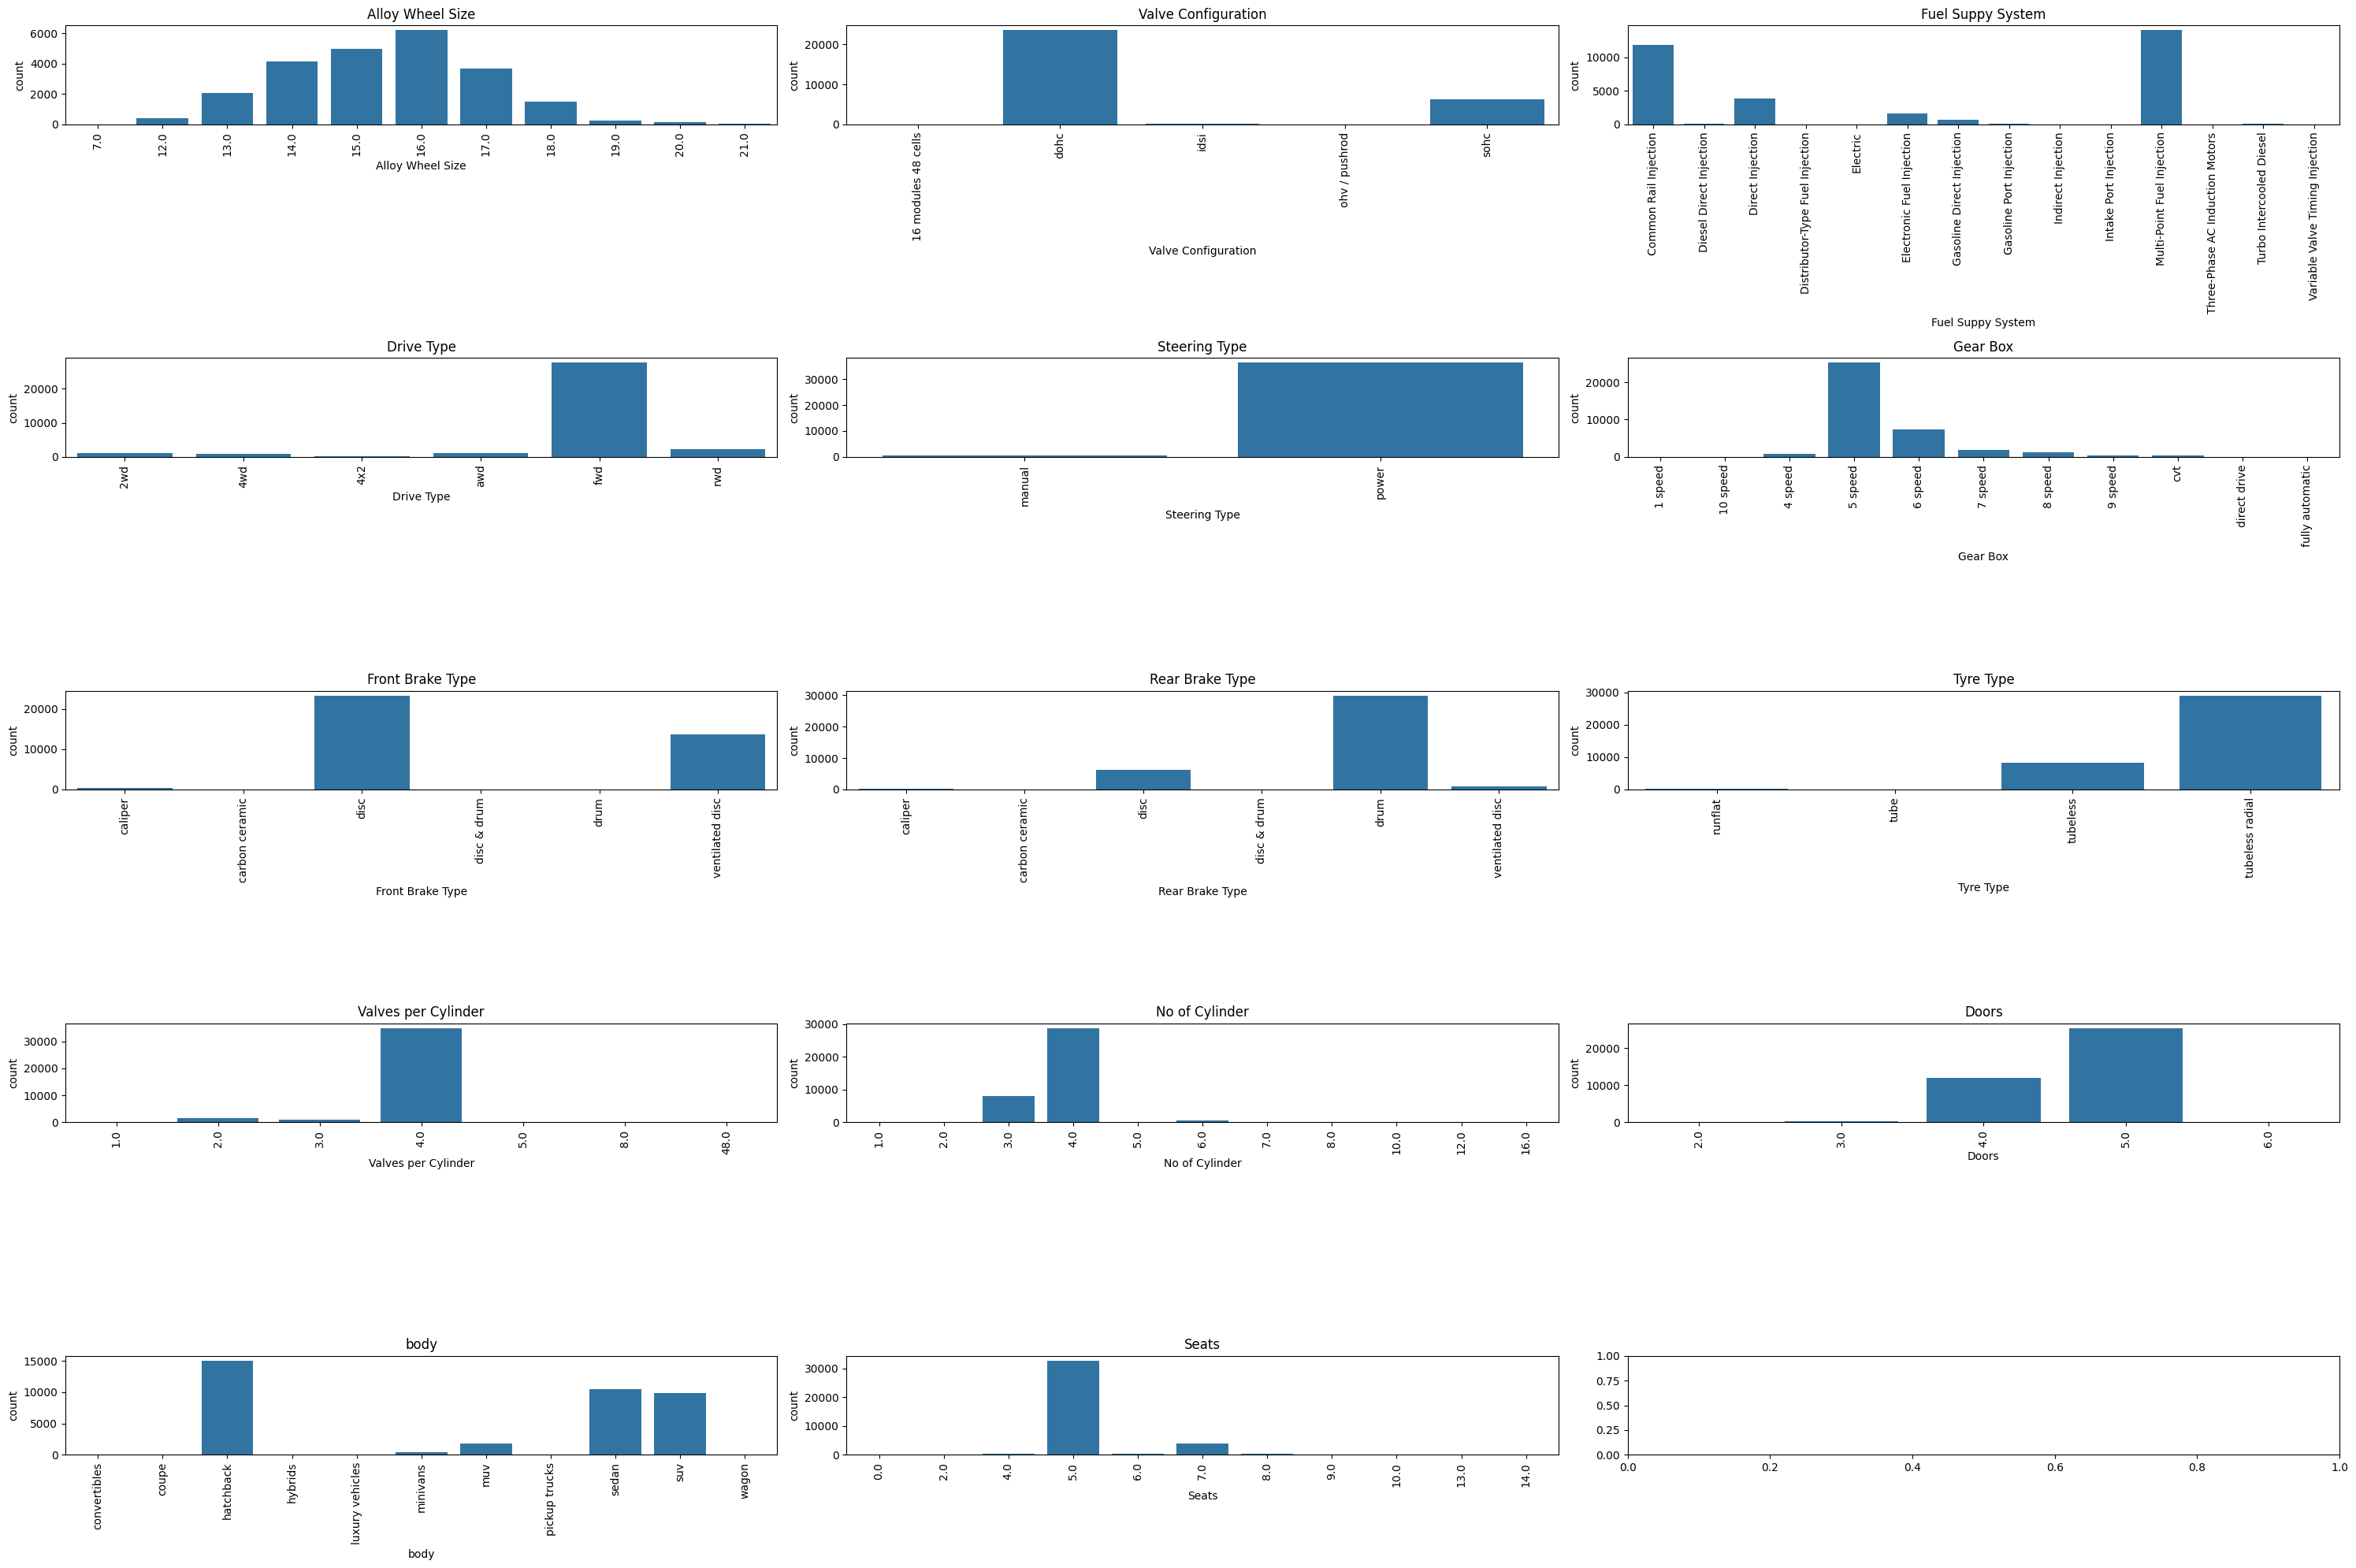

In [33]:
fig, axes = plt.subplots(
    round(len(na_column_type["categoric"]) / 3), 3, figsize=(30, 20)
)

for i, ax in enumerate(fig.axes):
    if i < len(na_column_type["categoric"]):
        col = na_column_type["categoric"][i]
        sns.countplot(
            data=df,
            x=col,
            order=df[col].value_counts().sort_index().index,
            ax=ax
        )
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=90)  # 🔹 X-tick rotation burada

fig.tight_layout()
plt.show()

Let's fill in the blank values ​​for categorical variables:

In [36]:
for col in na_column_type["categoric"]:
    if col in df.columns:
        if df[col].isna().mean() < 0.1:
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            valid_values = df[col].dropna().unique()
            if len(valid_values) > 0:
                df[col] = df[col].apply(
                    lambda x: np.random.choice(valid_values) if pd.isna(x) else x
                )

In [38]:
for col in na_column_type["cardinal"]:
    if col in df.columns:
        if df[col].isna().mean() < 0.1:
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna("unknown", inplace=True)

Examining the correlation between numeric variables containing null values and the dependent variable. Let's remove the one with the lowest correlation from the data set.

In [41]:
target = "listed_price"
corrs = df[na_column_type["numeric"] + [target]].corr()[target].sort_values(ascending=False)
corrs

listed_price            1.00
Kerb Weight             0.48
Max Power Delivered     0.25
Max Torque Delivered    0.21
Wheel Base              0.20
Width                   0.19
Top Speed               0.17
Length                  0.17
Cargo Volume            0.09
Height                  0.06
Turning Radius          0.00
Max Torque At          -0.07
Max Power At           -0.08
Acceleration           -0.15
Name: listed_price, dtype: float64

In [43]:
cols_keep = [
    "Kerb Weight", "Max Power Delivered", "Max Torque Delivered", 
    "Wheel Base", "Width", "Top Speed", "Length", "Acceleration"
]

cols_optional = ["Cargo Volume", "Height"]

cols_drop = ["Turning Radius", "Max Torque At", "Max Power At"]

Let's look at the average values in the breakdown of the numeric variable Body that we decided to keep in the data set:

                 TARGET_MEAN
body                        
convertibles         1615.00
coupe                1625.08
hatchback             942.34
hybrids              1505.00
luxury vehicles      1561.87
minivans              930.45
muv                  1446.63
pickup trucks        1845.77
sedan                1186.08
suv                  1495.04
wagon                 840.00


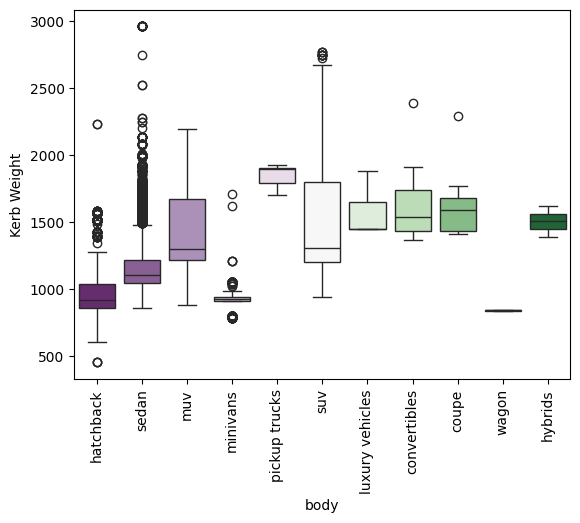

                 TARGET_MEAN
body                        
convertibles          304.91
coupe                 405.23
hatchback              73.71
hybrids               216.45
luxury vehicles       192.21
minivans               62.13
muv                   107.15
pickup trucks         109.36
sedan                 116.89
suv                   130.74
wagon                 135.10


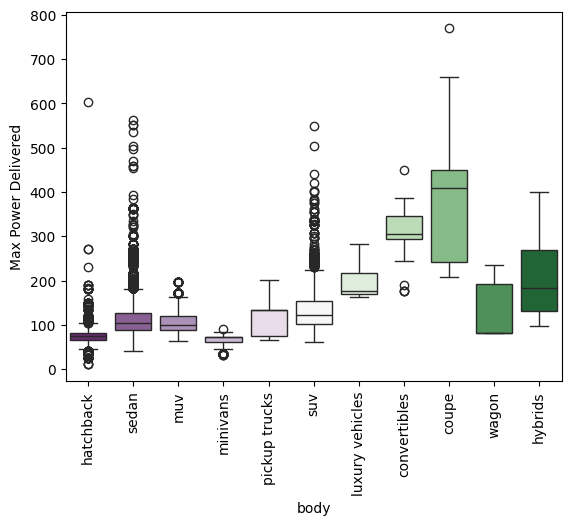

                 TARGET_MEAN
body                        
convertibles          377.00
coupe                 534.29
hatchback             110.53
hybrids               356.75
luxury vehicles       283.42
minivans               85.95
muv                   197.91
pickup trucks         271.19
sedan                 195.68
suv                   262.14
wagon                 247.43


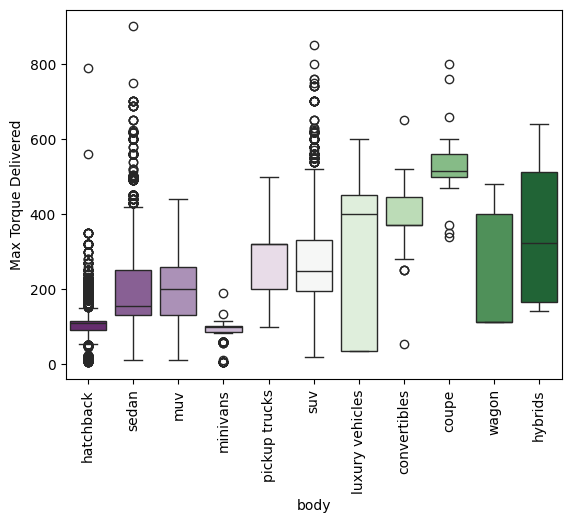

                 TARGET_MEAN
body                        
convertibles         2591.14
coupe                2725.40
hatchback            2435.65
hybrids              2861.00
luxury vehicles      2833.88
minivans             2243.92
muv                  2735.05
pickup trucks        3126.82
sedan                2593.47
suv                  2635.20
wagon                2651.29


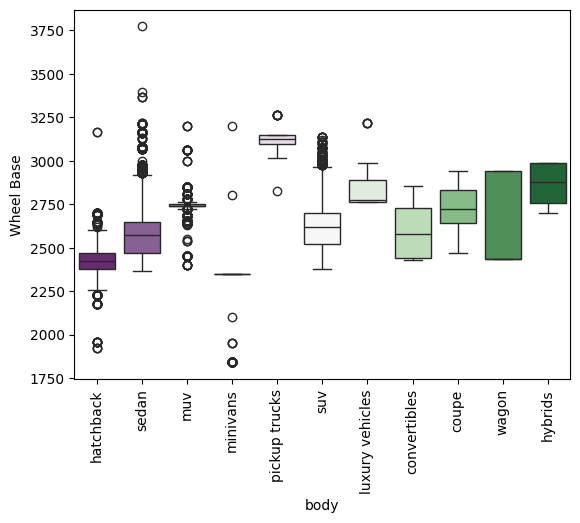

                 TARGET_MEAN
body                        
convertibles         1947.59
coupe                1979.71
hatchback            1637.26
hybrids              1968.50
luxury vehicles      1951.40
minivans             1464.70
muv                  1759.67
pickup trucks        1786.32
sedan                1745.43
suv                  1838.88
wagon                1808.86


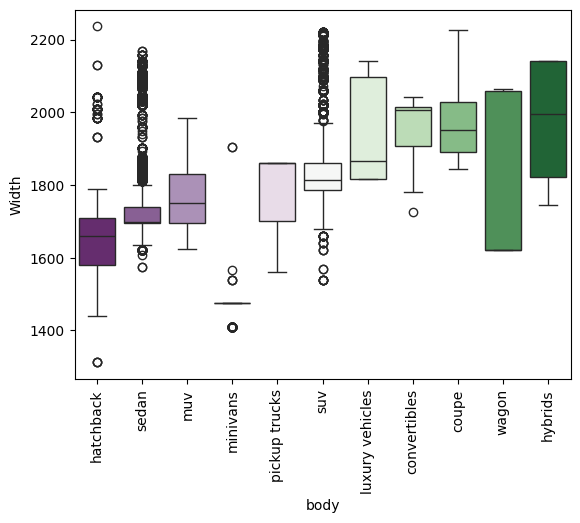

                 TARGET_MEAN
body                        
convertibles          252.29
coupe                 259.99
hatchback             157.53
hybrids               190.67
luxury vehicles       224.21
minivans              135.67
muv                   156.55
pickup trucks         135.36
sedan                 190.91
suv                   178.62
wagon                 230.67


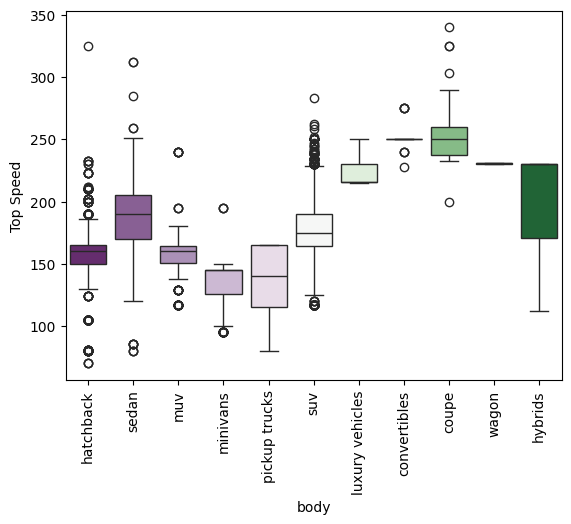

                 TARGET_MEAN
body                        
convertibles         4393.73
coupe                4645.10
hatchback            3745.88
hybrids              4823.25
luxury vehicles      4709.89
minivans             3619.36
muv                  4443.62
pickup trucks        5094.40
sedan                4392.06
suv                  4321.82
wagon                4207.57


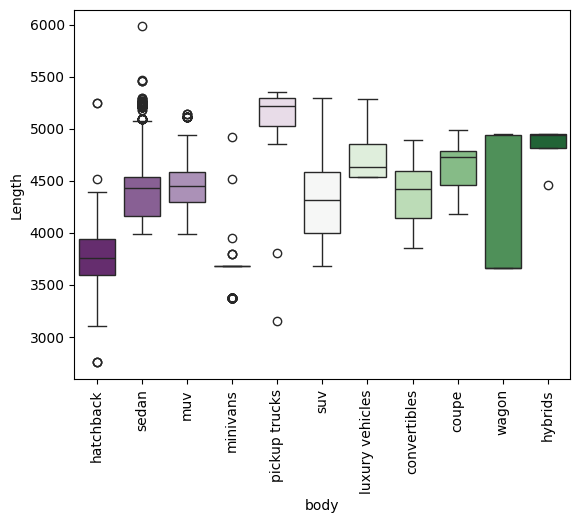

                 TARGET_MEAN
body                        
convertibles            5.87
coupe                   4.95
hatchback              14.60
hybrids                 9.67
luxury vehicles         8.74
minivans               16.75
muv                    14.98
pickup trucks          15.50
sedan                  11.54
suv                    12.12
wagon                  15.07


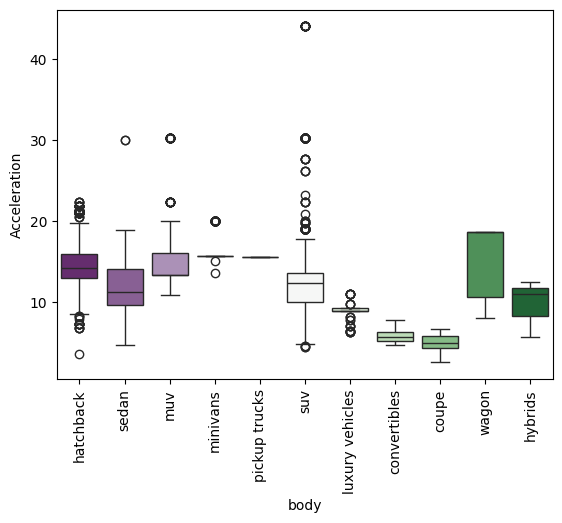

In [46]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col, observed=True)[target].mean()}))
    if plot:
        sns.boxplot(x = categorical_col, y = target, data=dataframe, palette="PRGn")
        plt.xticks(rotation=90)
        plt.show(block=True)

for col in cols_keep:
    target_summary_with_cat(df, col, "body", plot=True)

In [48]:
for col in cols_keep + cols_optional:
    if col in cols_keep:
        df[col] = df.groupby("body")[col].transform(lambda x: x.fillna(x.median()))
    else:
        df[col] = df[col].fillna(df[col].median())

df = df.drop(columns=cols_drop)

In [50]:
df.isnull().sum()

myear                   0
body                    0
transmission            0
fuel                    0
km                      0
oem                     0
model                   0
City                    0
listed_price            0
discountValue           0
Color                   0
Engine Type             0
No of Cylinder          0
Valves per Cylinder     0
Valve Configuration     0
Turbo Charger           0
Super Charger           0
Length                  0
Width                   0
Height                  0
Wheel Base              0
Kerb Weight             0
Gear Box                0
Drive Type              0
Seats                   0
Steering Type           0
Front Brake Type        0
Rear Brake Type         0
Top Speed               0
Acceleration            0
Tyre Type               0
Doors                   0
Cargo Volume            0
owner_type              0
Fuel Suppy System       0
Alloy Wheel Size        0
Max Power Delivered     0
Max Torque Delivered    0
dtype: int64

In [52]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 37813
Variables: 38
cat_cols_count: 19
num_cols_count: 14
cat_but_car_count: 5
num_but_cat_count: 5


In [54]:
# dublicate check

df[df.duplicated()].head()

myear             body transmission    fuel       km          oem  \
1427   2015              muv       manual  diesel 70000.00        honda   
1772   2018              muv    automatic  diesel 49200.00       toyota   
2665   2015  luxury vehicles    automatic  diesel 64000.00        volvo   
2768   2015            coupe    automatic  petrol 22800.00  lamborghini   
3146   2012              suv       manual  diesel 70000.00       toyota   

                     model        City  listed_price  discountValue   Color  \
1427         honda mobilio  barhalganj     500000.00              0   white   
1772  toyota innova crysta     kolkata    1850000.00              0   white   
2665           volvo xc 90      mumbai    3799999.00              0   white   
2768   lamborghini huracan      mumbai   22500000.00              0  orange   
3146       toyota fortuner   jalandhar    1280000.00              0   white   

                   Engine Type  No of Cylinder  Valves per Cylinder  \
1427             i-dtec engine            4.00                 4.00   
1772           1-gd ftv engine            4.00                 4.00   
2665  twin turbo diesel engine            4.00                 4.00   
2768      v type petrol engine           10.00                 4.00   
3146        d-4d diesel engine            4.00                 4.00   

     Valve Configuration  Turbo Charger  Super Charger  Length   Width  \
1427                dohc           True           True 4398.00 1683.00   
1772                dohc           True           True 4735.00 1830.00   
2665                dohc           True           True 4950.00 2140.00   
2768                dohc          False          False 4459.00 1924.00   
3146                dohc           True           True 4705.00 1840.00   

      Height  Wheel Base  Kerb Weight Gear Box Drive Type  Seats  \
1427 1603.00     2652.00      1254.00  5 speed        fwd   7.00   
1772 1795.00     2750.00      1880.00  6 speed        rwd   7.00   
2665 1776.00     2984.00      1445.00  8 speed        awd   7.00   
2768 1165.00     2620.00      1422.00  7 speed        awd   2.00   
3146 1850.00     2750.00      1880.00  5 speed        fwd   7.00   

     Steering Type Front Brake Type Rear Brake Type  Top Speed  Acceleration  \
1427         power             disc            drum     165.00         14.00   
1772         power             disc            drum     160.00         13.30   
2665         power             disc            disc     230.00         10.90   
2768         power          caliper         caliper     325.00          3.20   
3146         power  ventilated disc            drum     176.00          9.60   

            Tyre Type  Doors  Cargo Volume owner_type      Fuel Suppy System  \
1427  tubeless radial   5.00        223.00     second  Common Rail Injection   
1772  tubeless radial   5.00        350.00      first       Direct Injection   
2665         tubeless   5.00        300.00      first       Direct Injection   
2768  tubeless radial   2.00        480.00      first       Direct Injection   
3146  tubeless radial   5.00        296.00      first  Common Rail Injection   

      Alloy Wheel Size  Max Power Delivered  Max Torque Delivered  
1427             15.00                98.60                200.00  
1772             17.00               171.50                360.00  
2665             20.00               235.00                480.00  
2768             20.00               602.12                560.00  
3146             17.00               168.50                343.00

In [56]:
df = df.drop_duplicates(keep="first", ignore_index=True)
df[df.duplicated()]

Empty DataFrame
Columns: [myear, body, transmission, fuel, km, oem, model, City, listed_price, discountValue, Color, Engine Type, No of Cylinder, Valves per Cylinder, Valve Configuration, Turbo Charger, Super Charger, Length, Width, Height, Wheel Base, Kerb Weight, Gear Box, Drive Type, Seats, Steering Type, Front Brake Type, Rear Brake Type, Top Speed, Acceleration, Tyre Type, Doors, Cargo Volume, owner_type, Fuel Suppy System, Alloy Wheel Size, Max Power Delivered, Max Torque Delivered]
Index: []

# 3. Exploratory Data Analysis

In [59]:
df.head()

myear       body transmission fuel        km     oem           model  \
0   2016  hatchback       manual  cng  69162.00  maruti  maruti wagon r   
1   2015  hatchback       manual  cng  45864.00  maruti  maruti celerio   
2   2015      sedan       manual  cng  81506.00   honda     honda amaze   
3   2013  hatchback       manual  cng 115893.00  maruti  maruti wagon r   
4   2022        muv       manual  cng  18900.00  maruti   maruti ertiga   

        City  listed_price  discountValue   Color             Engine Type  \
0    lucknow     370000.00              0  silver             k10b engine   
1     mumbai     365000.00              0    grey             k10b engine   
2  new delhi     421000.00              0  silver    i-vtec petrol engine   
3  new delhi     240000.00              0  silver  k series petrol engine   
4     mumbai    1175000.00              0   white                    k15c   

   No of Cylinder  Valves per Cylinder Valve Configuration  Turbo Charger  \
0            3.00                 4.00                dohc          False   
1            3.00                 4.00                dohc          False   
2            4.00                 4.00                sohc          False   
3            3.00                 4.00                dohc          False   
4            4.00                 4.00       ohv / pushrod           True   

   Super Charger  Length   Width  Height  Wheel Base  Kerb Weight Gear Box  \
0          False 3599.00 1495.00 1700.00     2400.00       960.00  5 speed   
1          False 3600.00 1600.00 1560.00     2425.00       915.00  5 speed   
2          False 3990.00 1680.00 1505.00     2405.00       950.00  5 speed   
3          False 3595.00 1475.00 1700.00     2400.00       960.00  5 speed   
4           True 4395.00 1735.00 1690.00     2740.00      1250.00  5 speed   

  Drive Type  Seats Steering Type Front Brake Type Rear Brake Type  Top Speed  \
0        fwd   5.00         power  ventilated disc            drum     137.00   
1        fwd   5.00         power  ventilated disc            drum     150.00   
2        fwd   5.00         power             disc            drum     160.00   
3        fwd   5.00         power  ventilated disc            drum     160.00   
4        2wd   7.00         power             disc            drum     160.00   

   Acceleration        Tyre Type  Doors  Cargo Volume owner_type  \
0         15.90         tubeless   5.00        180.00      first   
1         15.05  tubeless radial   5.00        235.00      first   
2         15.00  tubeless radial   4.00        400.00     second   
3         14.20  tubeless radial   4.00        350.00     second   
4         13.30  tubeless radial   5.00        350.00      first   

                 Fuel Suppy System  Alloy Wheel Size  Max Power Delivered  \
0       Multi-Point Fuel Injection             13.00                58.16   
1          Gasoline Port Injection             17.00                58.20   
2                         Electric             20.00                86.70   
3       Multi-Point Fuel Injection             13.00                58.20   
4  Distributor-Type Fuel Injection             15.00                86.63   

   Max Torque Delivered  
0                 77.00  
1                 78.00  
2                109.00  
3                 77.00  
4                121.50

In [61]:
df.describe().T

count      mean        std      min       25%  \
myear                37744.00   2015.57       3.78  1983.00   2013.00   
km                   37744.00  62431.06   58514.23   101.00  31738.75   
listed_price         37744.00 797475.87 3042526.04 11963.00 320000.00   
discountValue        37744.00     73.42    2808.35     0.00      0.00   
No of Cylinder       37744.00      3.82       0.54     1.00      4.00   
Valves per Cylinder  37744.00      3.89       0.48     1.00      4.00   
Length               37744.00   4111.96     398.60  2752.00   3780.00   
Width                37744.00   1724.86     127.82  1312.00   1677.00   
Height               37744.00   1577.08     114.63  1165.00   1495.00   
Wheel Base           37744.00   2545.49     154.85  1840.00   2425.00   
Kerb Weight          37744.00   1142.01     277.34   451.00    920.00   
Seats                37744.00      5.24       0.72     0.00      5.00   
Top Speed            37744.00    172.22      21.94    70.00    160.00   
Acceleration         37744.00     13.03       2.73     2.50     11.20   
Doors                37744.00      4.66       0.50     2.00      4.00   
Cargo Volume         37744.00    360.60     118.28    20.00    280.00   
Alloy Wheel Size     37744.00     15.51       2.68     7.00     14.00   
Max Power Delivered  37744.00    102.56      42.56    10.80     74.02   
Max Torque Delivered 37744.00    178.31     105.97     4.80    110.00   

                           50%       75%          max  
myear                  2016.00   2018.00      2023.00  
km                    56760.00  83347.00   6300000.00  
listed_price         525000.00 851015.00 550000555.00  
discountValue             0.00      0.00    200000.00  
No of Cylinder            4.00      4.00        16.00  
Valves per Cylinder       4.00      4.00        48.00  
Length                 3995.00   4440.00      5982.00  
Width                  1710.00   1790.00      2236.00  
Height                 1530.00   1642.00      2075.00  
Wheel Base             2520.00   2642.00      3772.00  
Kerb Weight            1103.00   1305.00      2962.00  
Seats                     5.00      5.00        14.00  
Top Speed               170.00    185.00       340.00  
Acceleration             12.90     14.20        44.04  
Doors                     5.00      5.00         6.00  
Cargo Volume            350.00    433.00      2055.00  
Alloy Wheel Size         16.00     17.00        21.00  
Max Power Delivered      88.50    118.35       769.31  
Max Torque Delivered    145.00    220.00       900.00

* The difference between the median and mean is noticeable for the variables listed_price, discountValue, Maximum Power Delivered, and Maximum Torque Delivered. These variables appear to have a skewed distribution.
* When observing the 75% quartile and maximum values, it is understood that there are outliers in the data set.

## 3.1 Target Variable Analysis

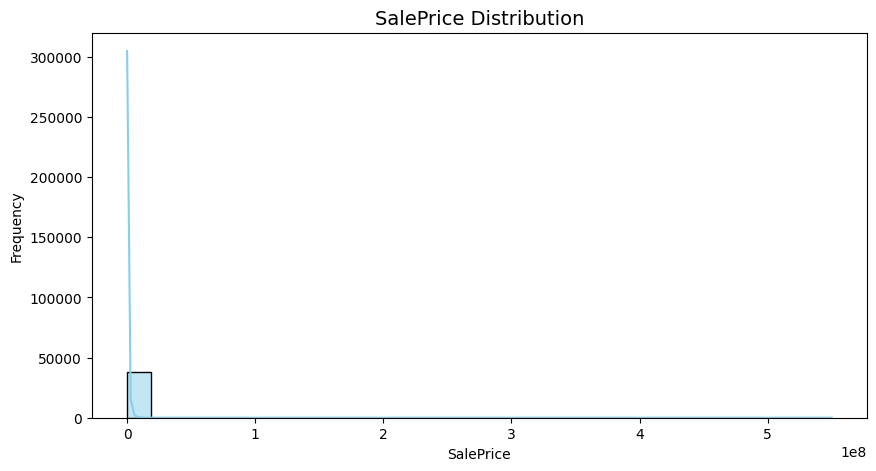

Skewness before log transformation: 156.9781


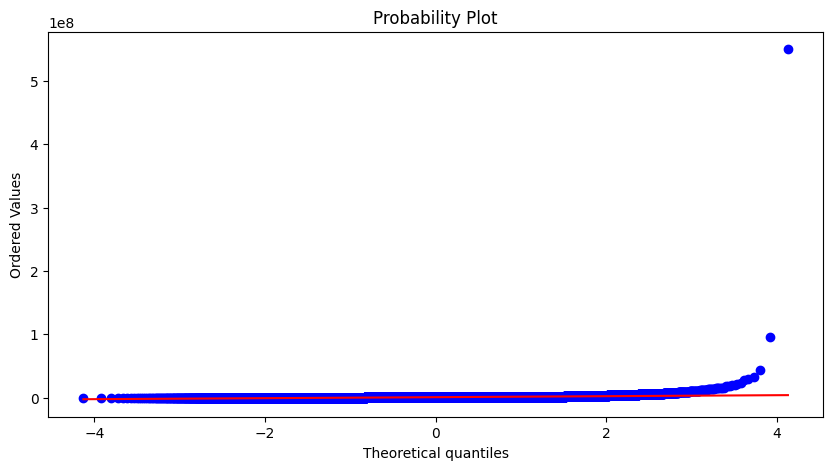

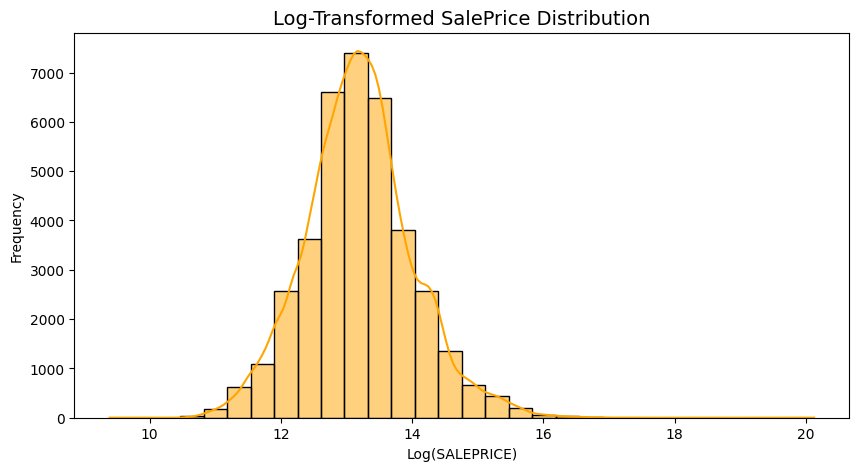

Skewness after log transformation: 0.2895


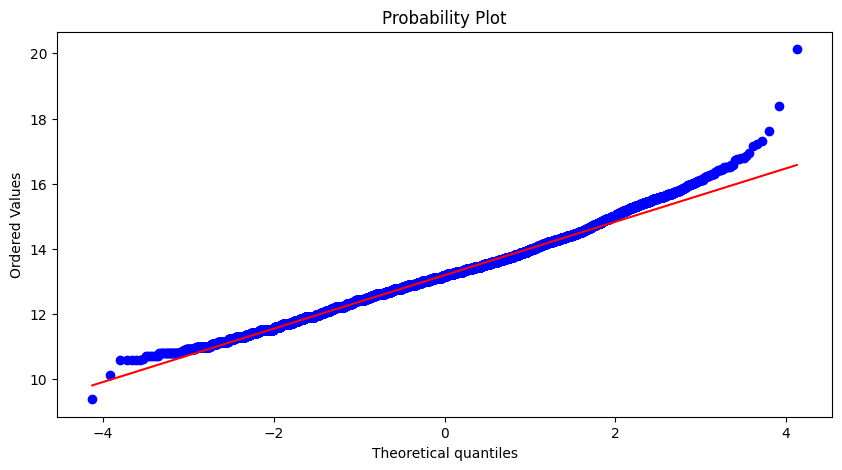

In [67]:
# Visualize orginal distribution
plt.figure(figsize = (10,5))
sns.histplot(df["listed_price"], kde = True, bins = 30, color = "skyblue")
plt.title("SalePrice Distribution", fontsize = 14)
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

orginal_skew = df["listed_price"].skew()
print(f"Skewness before log transformation: {orginal_skew:.4f}")

plt.figure(figsize=(10, 5))
stats.probplot(df["listed_price"], plot=plt)
plt.show()

# Apply log1p transformation
df["listed_price_log"] = np.log1p(df["listed_price"])

# Visualize transformed distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["listed_price_log"] , kde=True, bins=30, color="orange")
plt.title("Log-Transformed SalePrice Distribution", fontsize=14)
plt.xlabel("Log(SALEPRICE)")
plt.ylabel("Frequency")
plt.show()

# Check new skewness
log_skew = df["listed_price_log"].skew()
print(f"Skewness after log transformation: {log_skew:.4f}")

plt.figure(figsize=(10, 5))
stats.probplot(df["listed_price_log"], plot=plt)
plt.show()

In regression problems, the closer the dependent variable is to a normal distribution, the better results we get.We will keep the logarithmically transformed target variable in the data set.

In [70]:
df.drop("listed_price",axis=1,inplace=True)

In [72]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 37744
Variables: 38
cat_cols_count: 19
num_cols_count: 14
cat_but_car_count: 5
num_but_cat_count: 5


## 3.2 Effect of Numerical Variables on Dependent Variable

In [74]:
corr = df[num_cols].corr()['listed_price_log'].sort_values(ascending=False)
corr

listed_price_log        1.00
Width                   0.71
Max Power Delivered     0.71
Max Torque Delivered    0.67
Wheel Base              0.67
myear                   0.66
Length                  0.62
Kerb Weight             0.58
Top Speed               0.52
Cargo Volume            0.34
Height                  0.27
discountValue           0.04
km                     -0.21
Acceleration           -0.50
Name: listed_price_log, dtype: float64

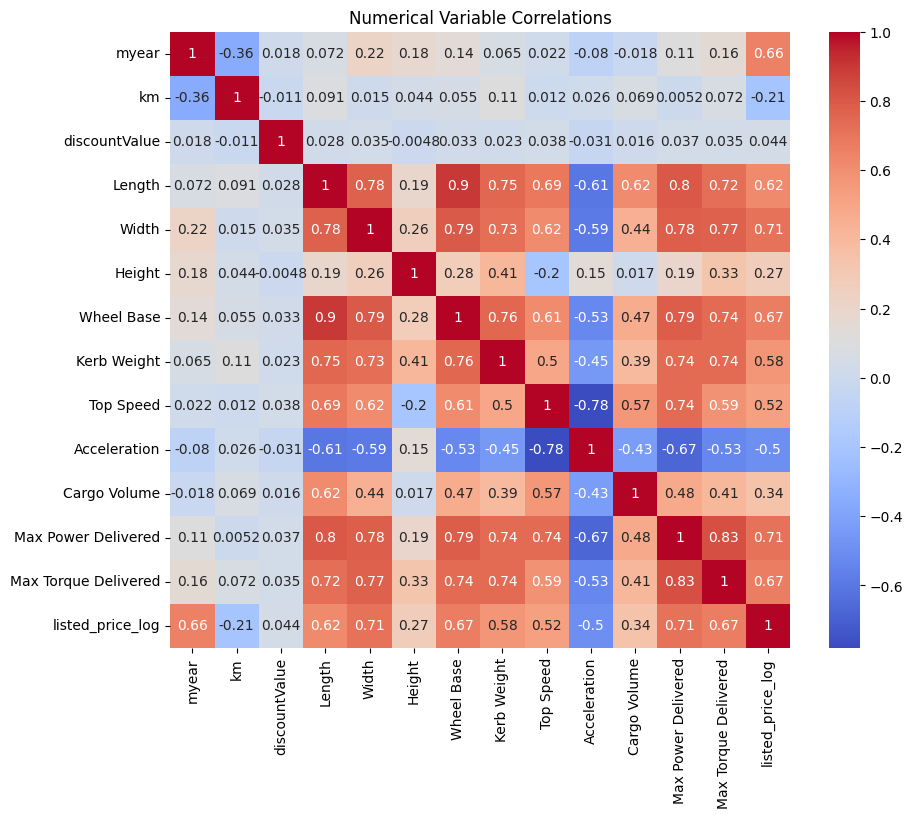

In [76]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title('Numerical Variable Correlations')
plt.show()

Let's identify those with a correlation above 80% and remove them from the data set.

In [79]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.80):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

drop_list = high_correlated_cols(df[num_cols])
drop_list

['Wheel Base', 'Max Torque Delivered']

In [81]:
df.drop(drop_list, axis=1, inplace=True)

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 37744
Variables: 36
cat_cols_count: 19
num_cols_count: 12
cat_but_car_count: 5
num_but_cat_count: 5


## 3.3 Effect of Categorical Variables on Dependent Variable

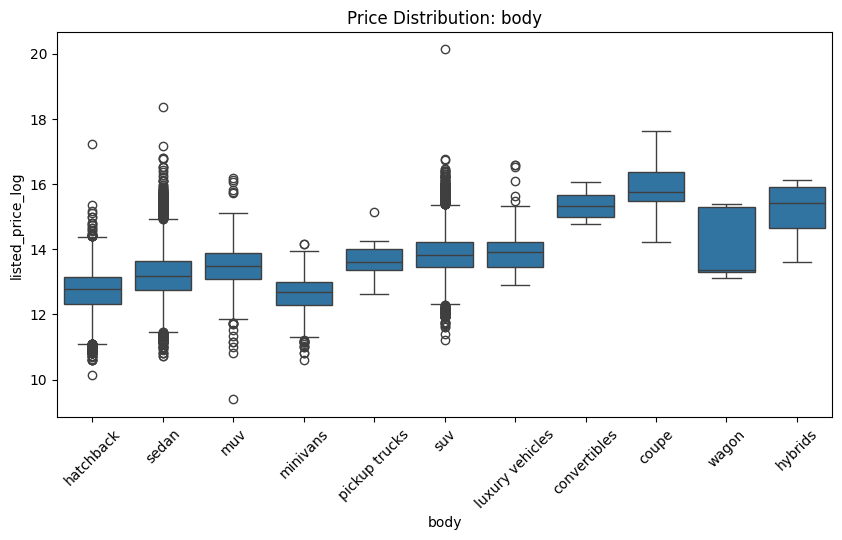

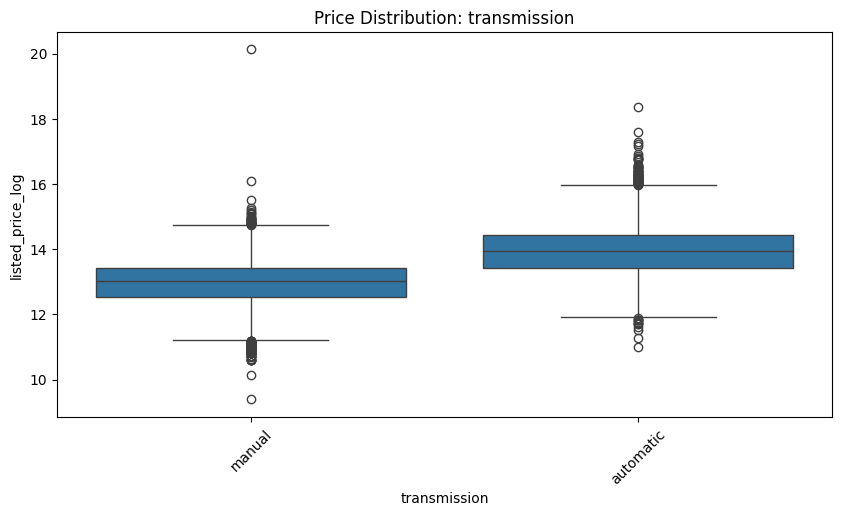

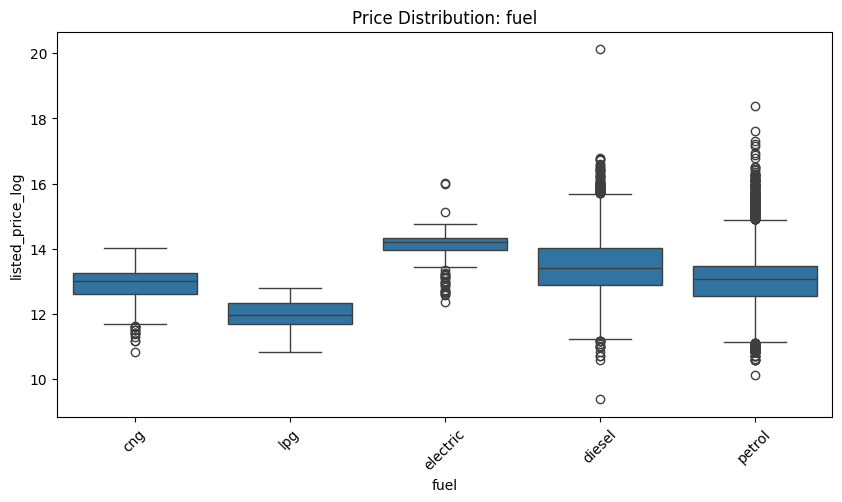

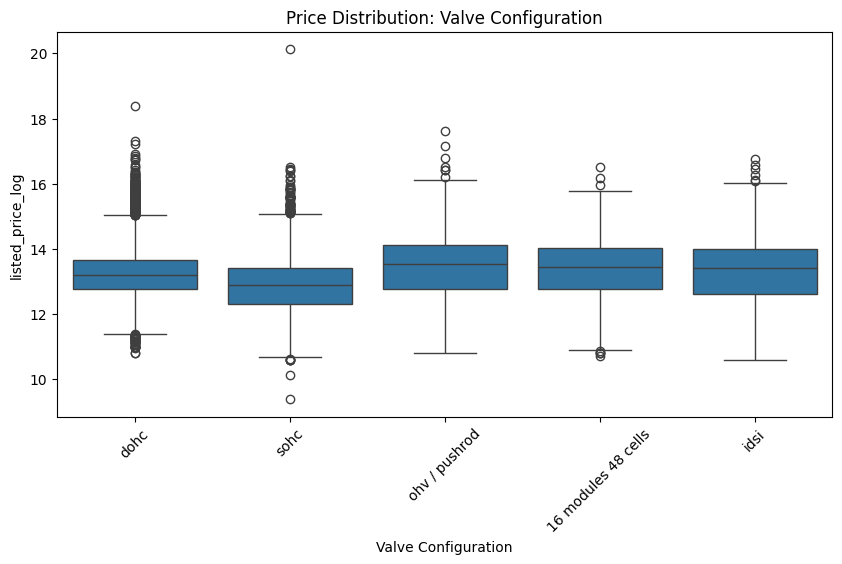

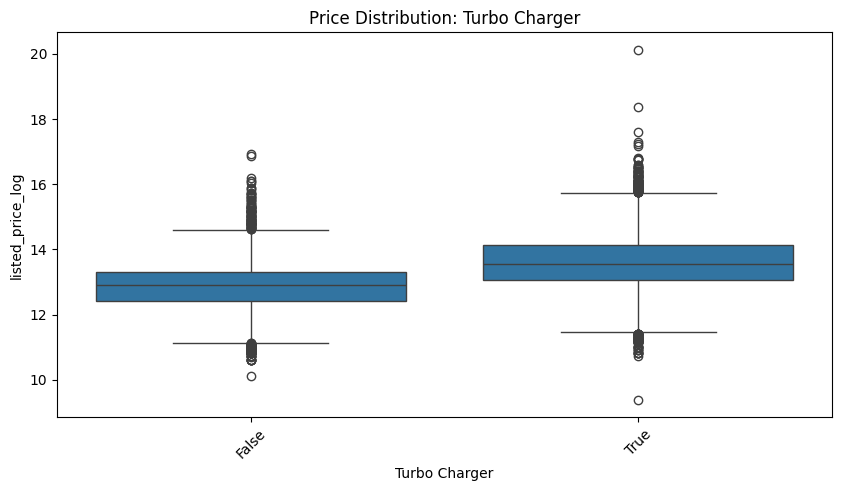

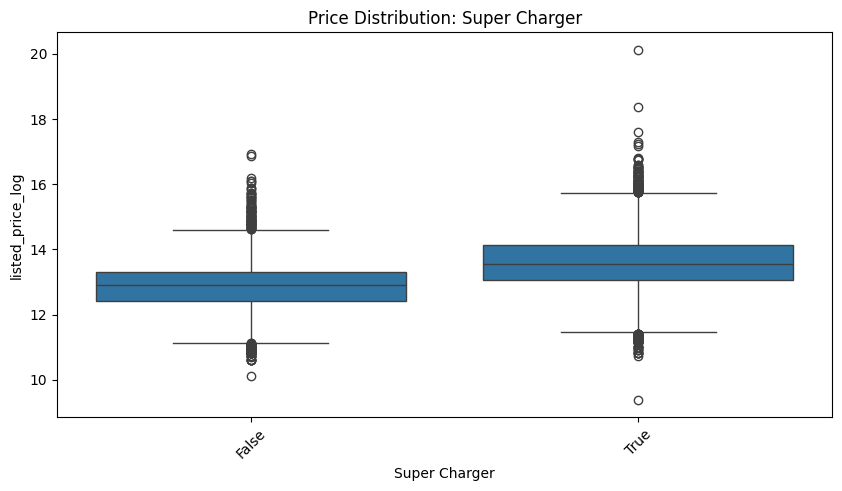

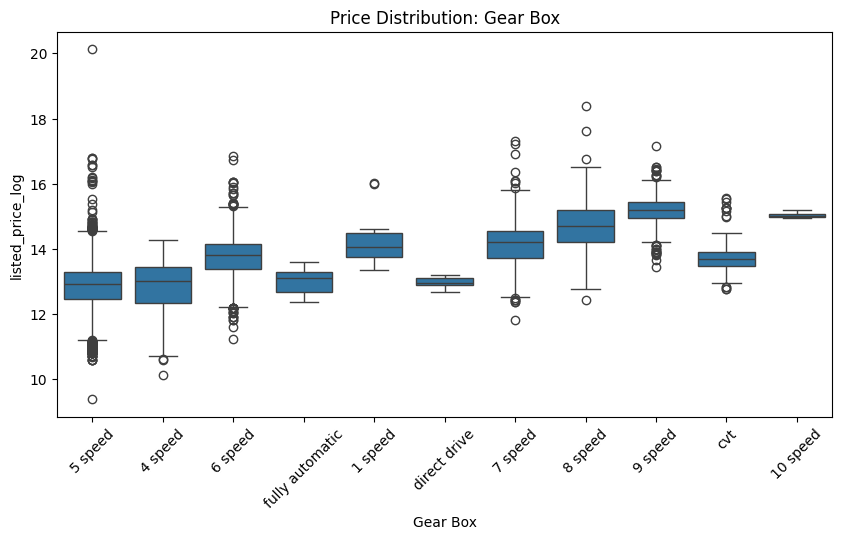

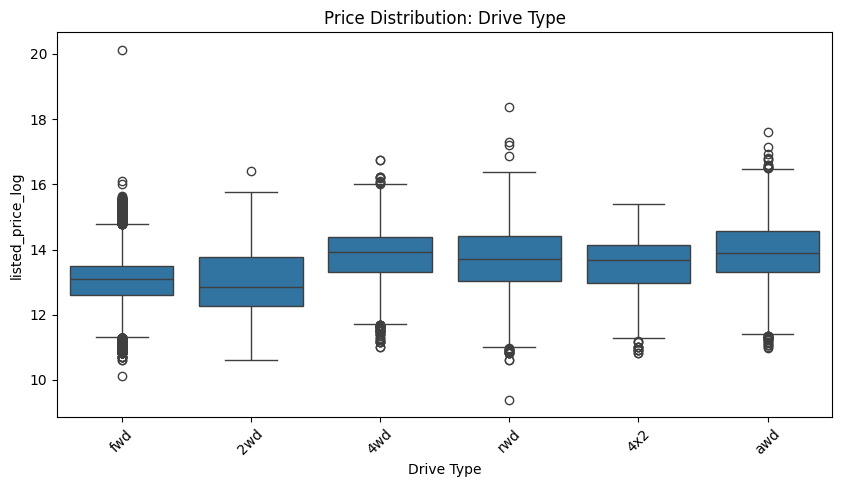

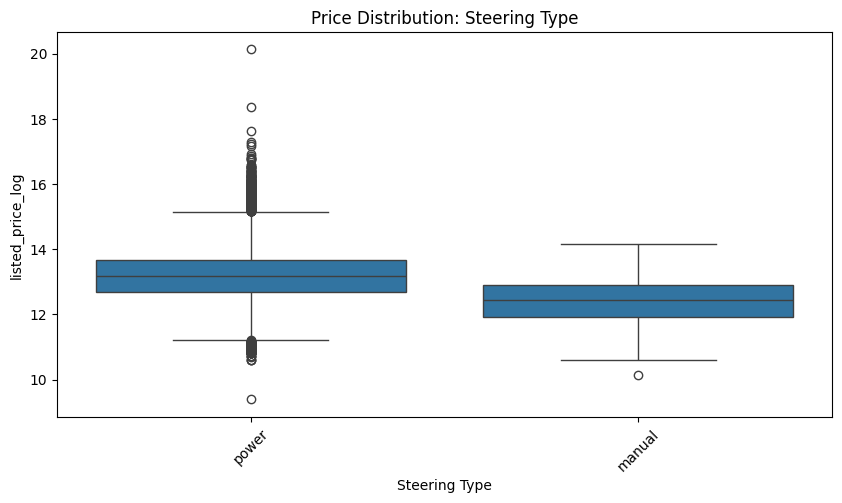

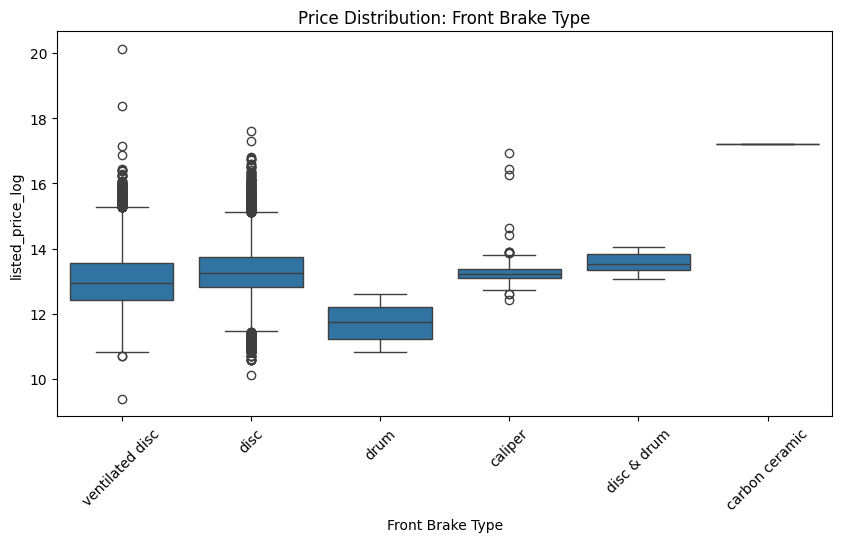

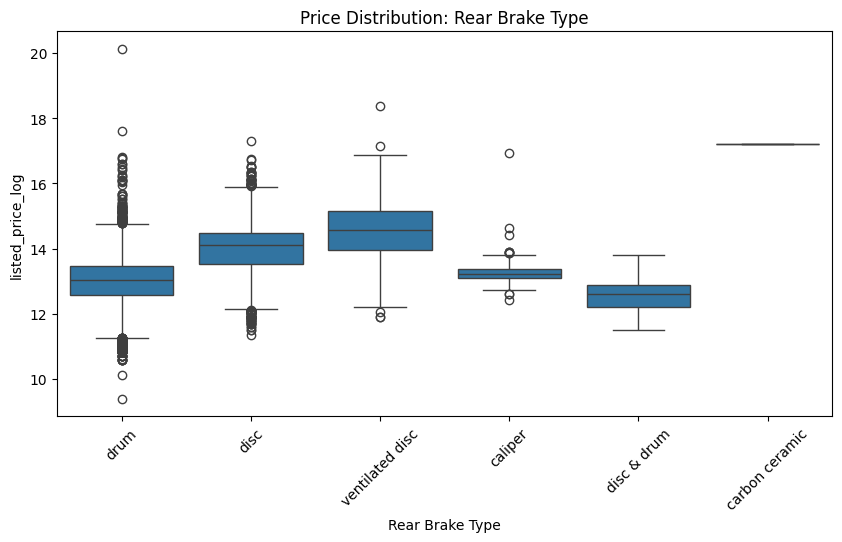

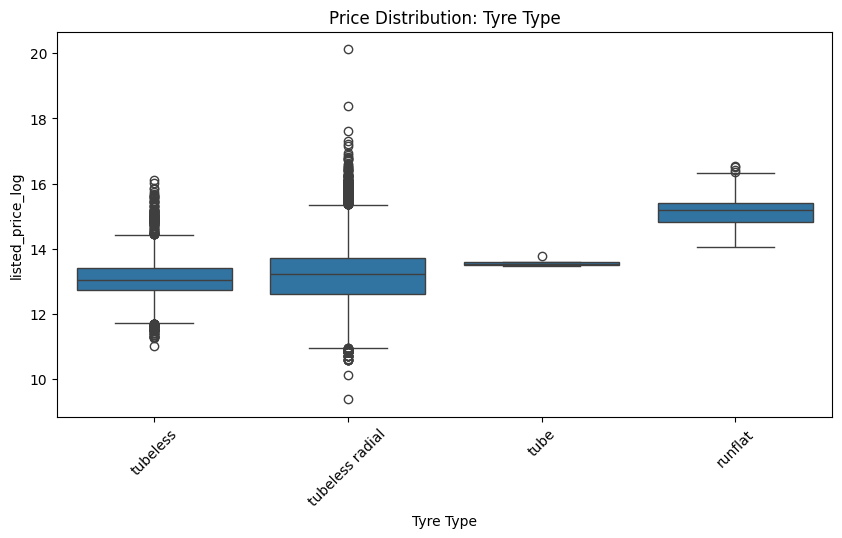

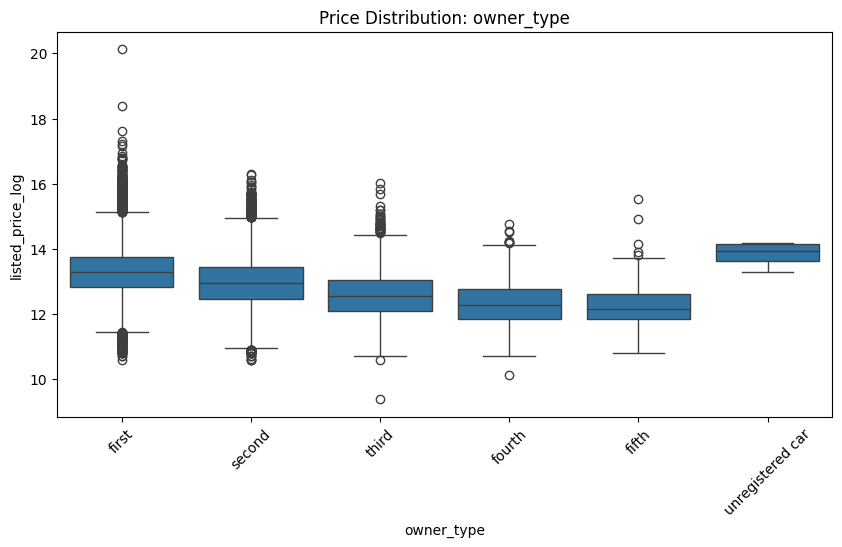

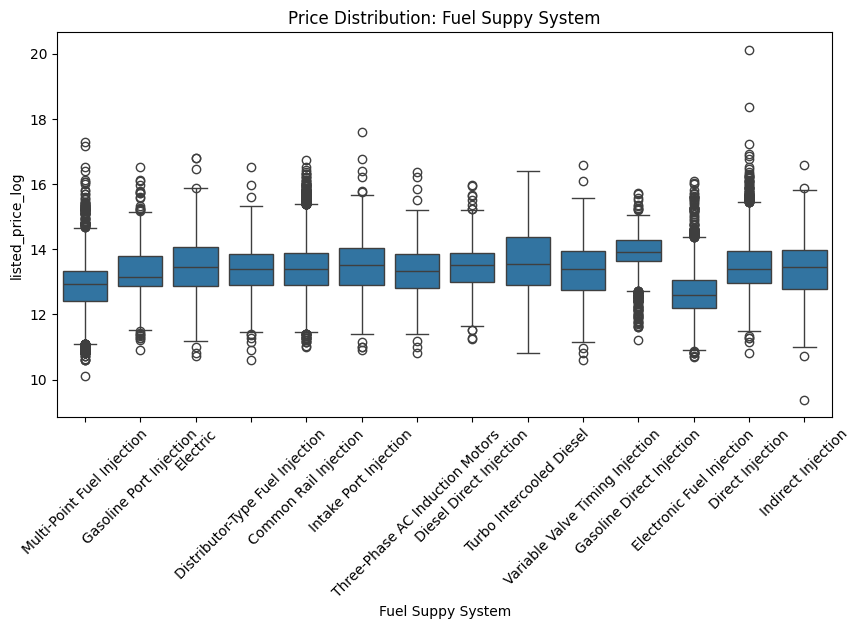

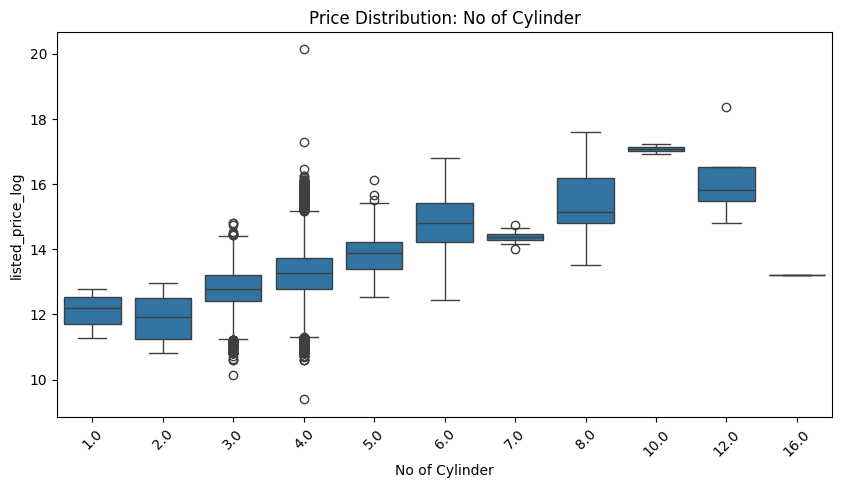

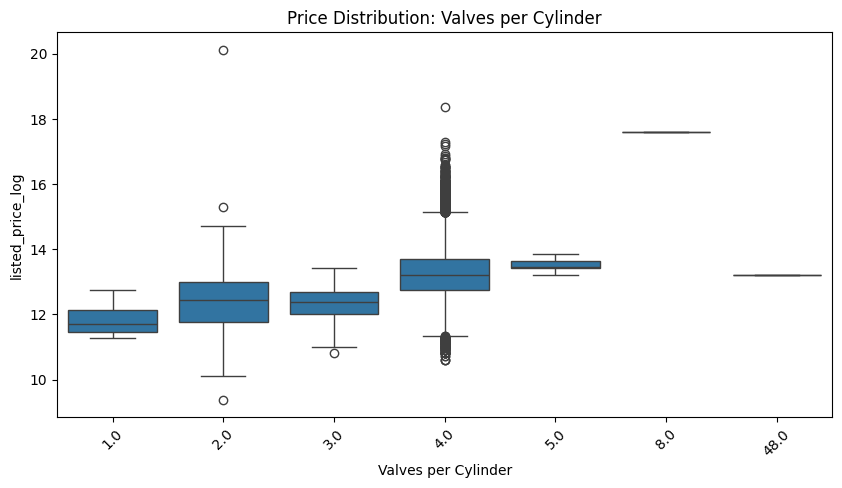

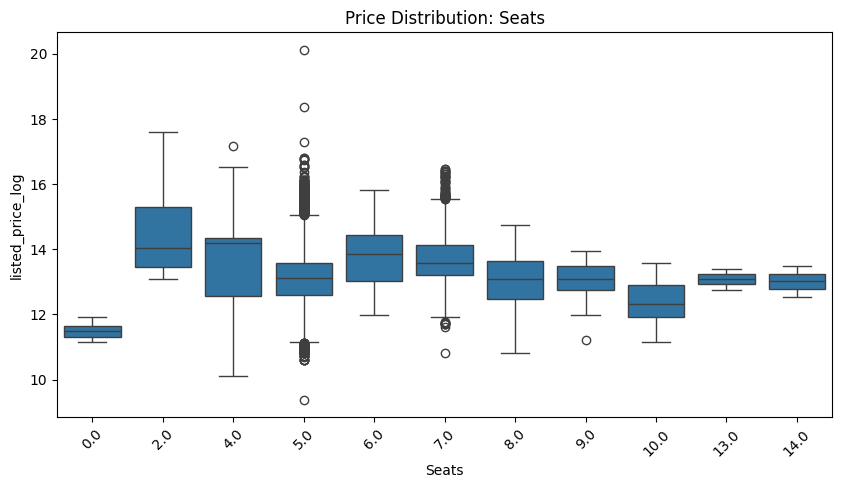

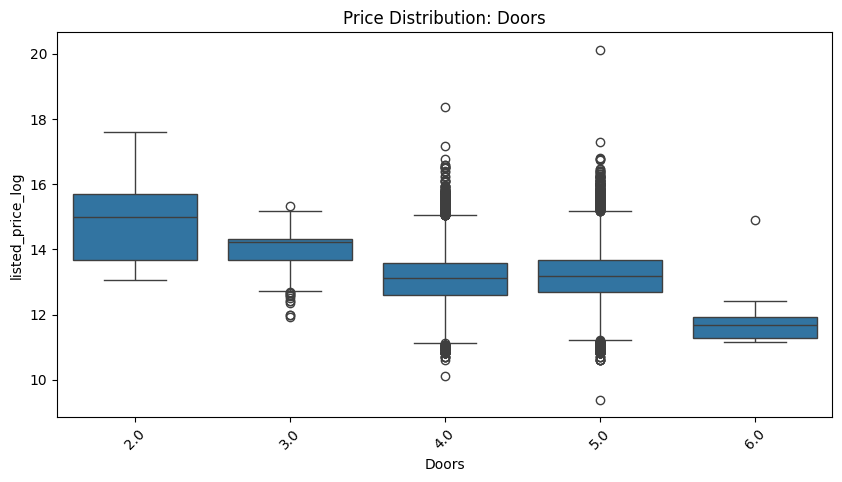

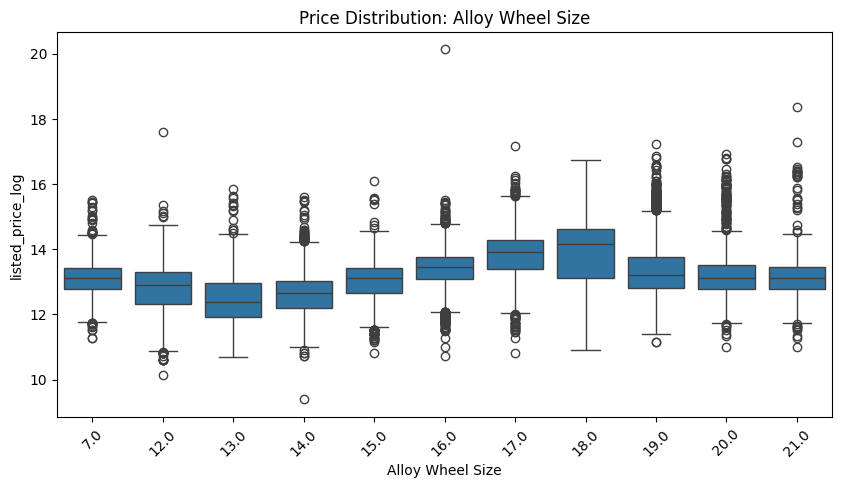

In [83]:
for col in cat_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df, x=col, y="listed_price_log")
    plt.title(f'Price Distribution: {col}')
    plt.xticks(rotation=45)
    plt.show()

## 3.4 Distribution of Numerical Variables

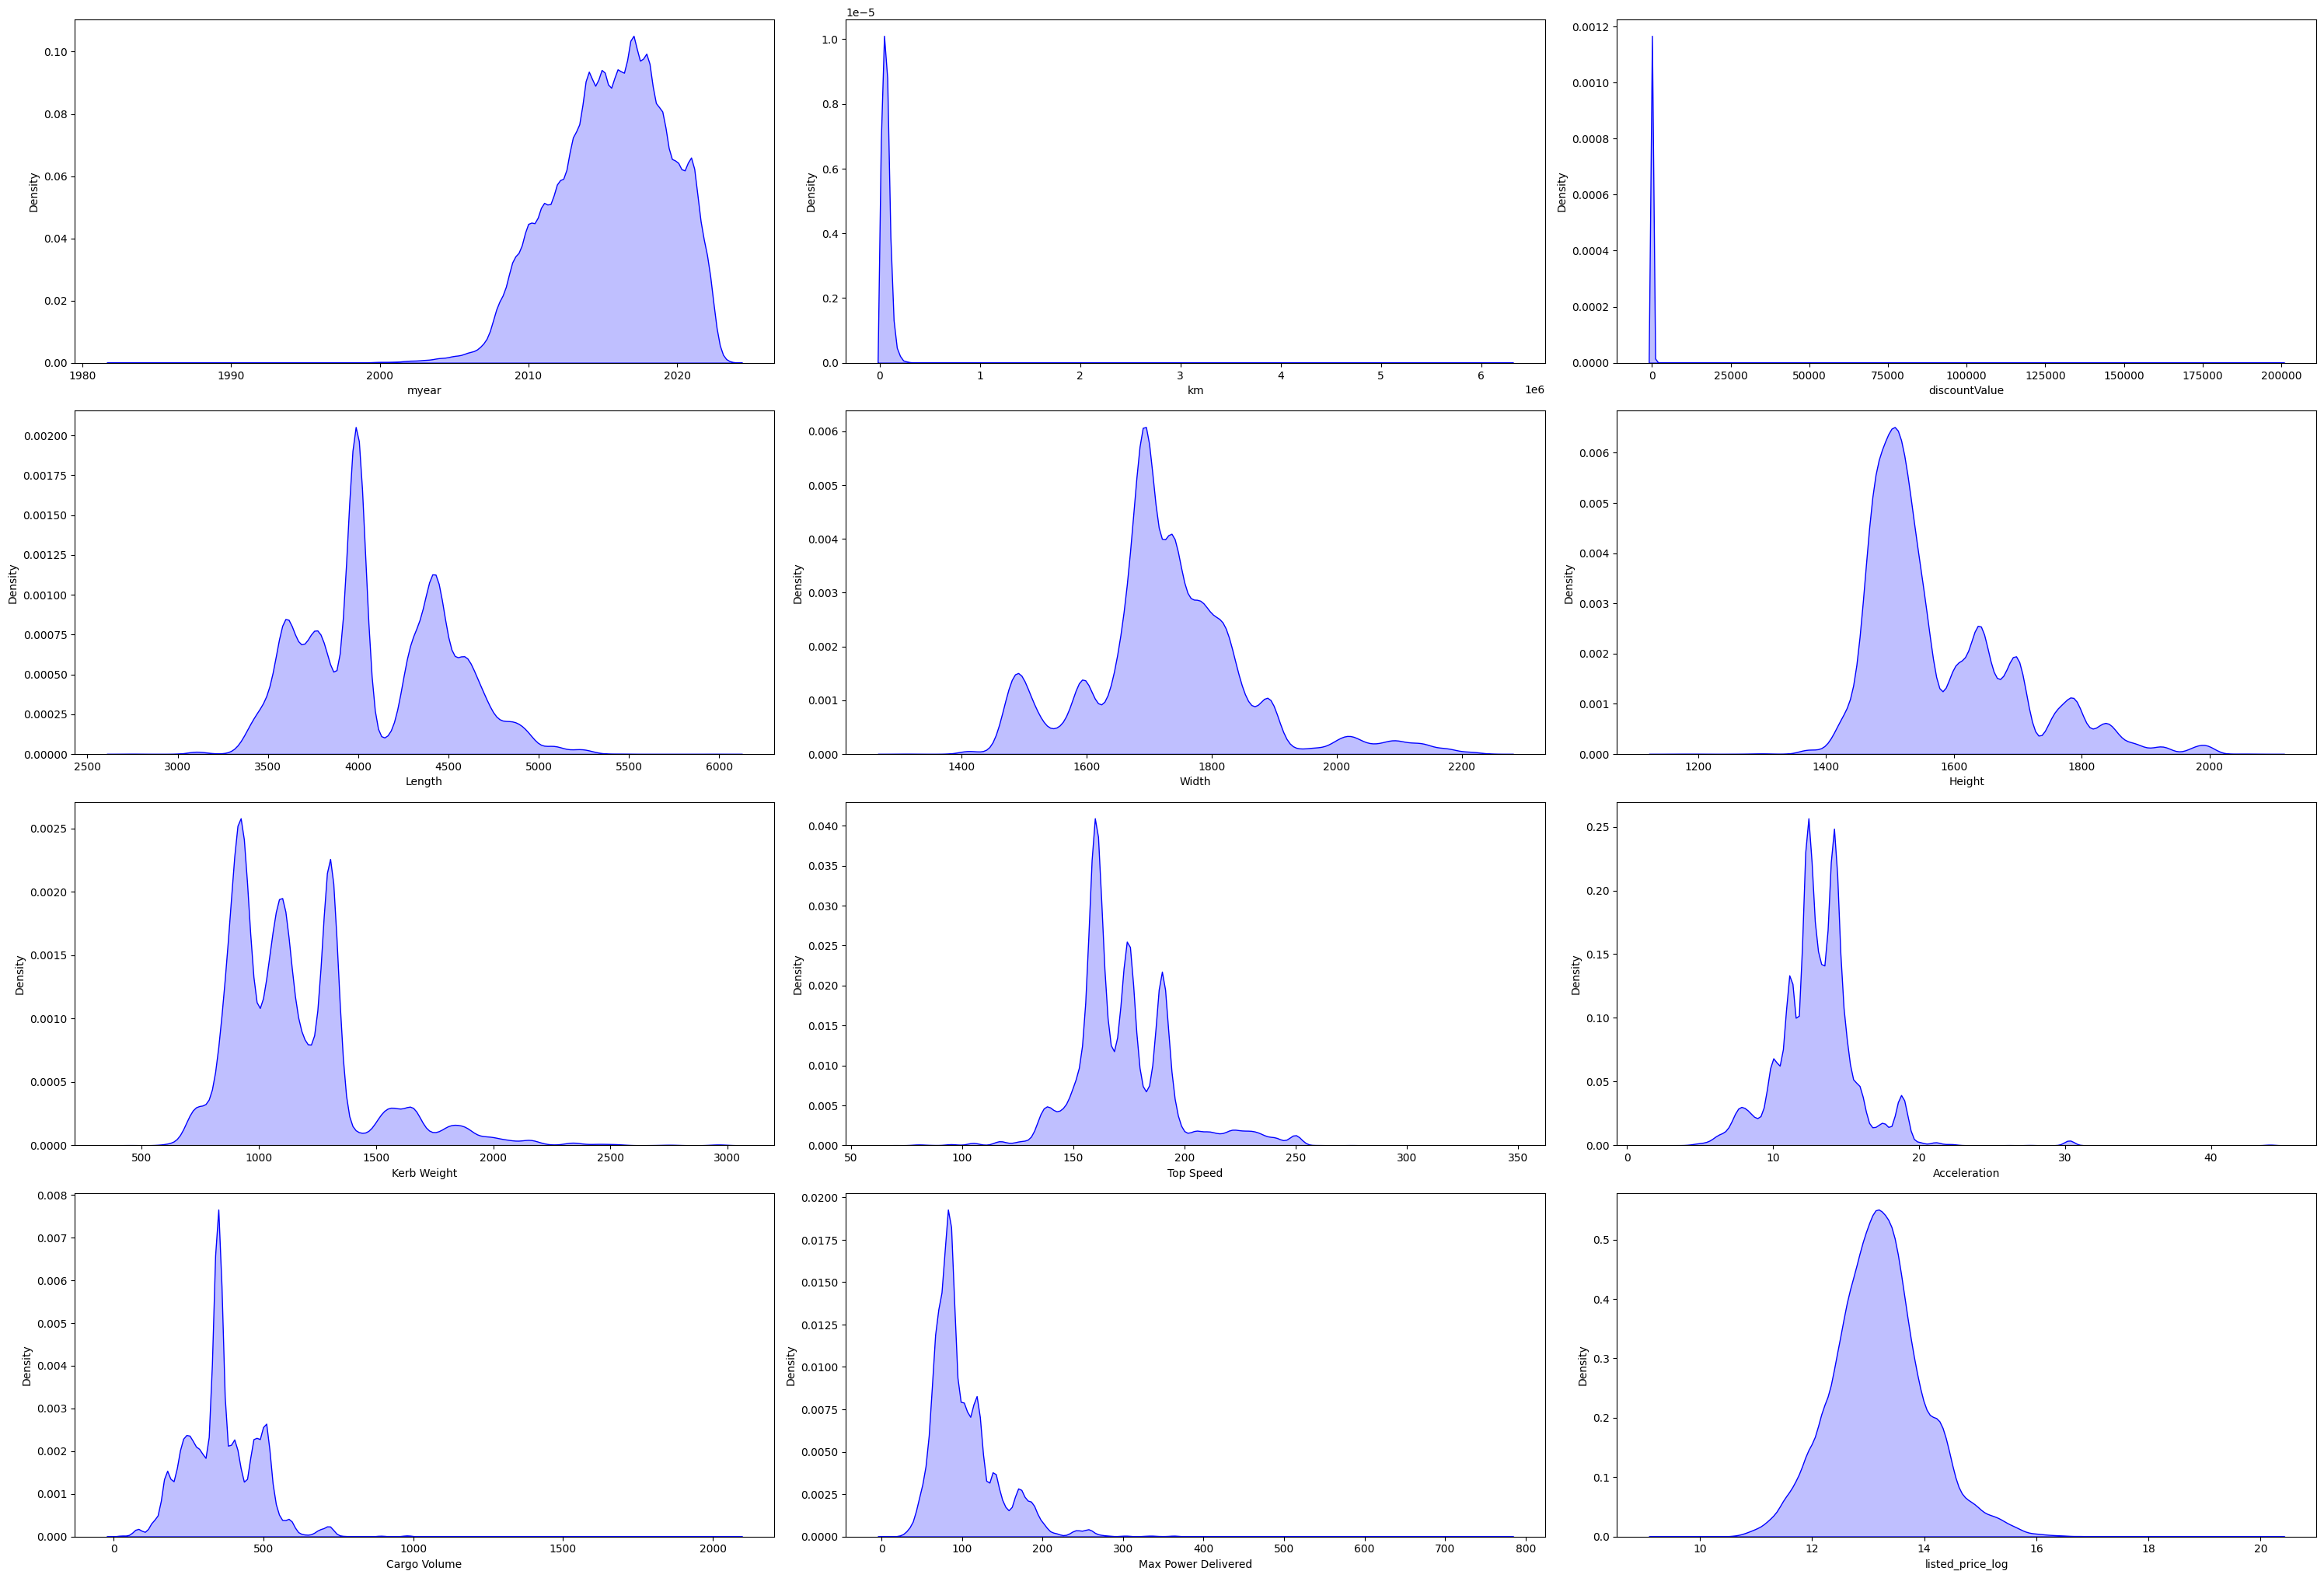

In [85]:
plt.figure(figsize=(30,25))

for i in range(0, len(num_cols)):
    plt.subplot(5,3,i+1)
    sns.kdeplot(x=df[num_cols[i]], color = "b", fill=True)
    plt.xlabel(num_cols[i])
    plt.tight_layout()
plt.show()

## 3.5 Count Charts of Categorical Variables

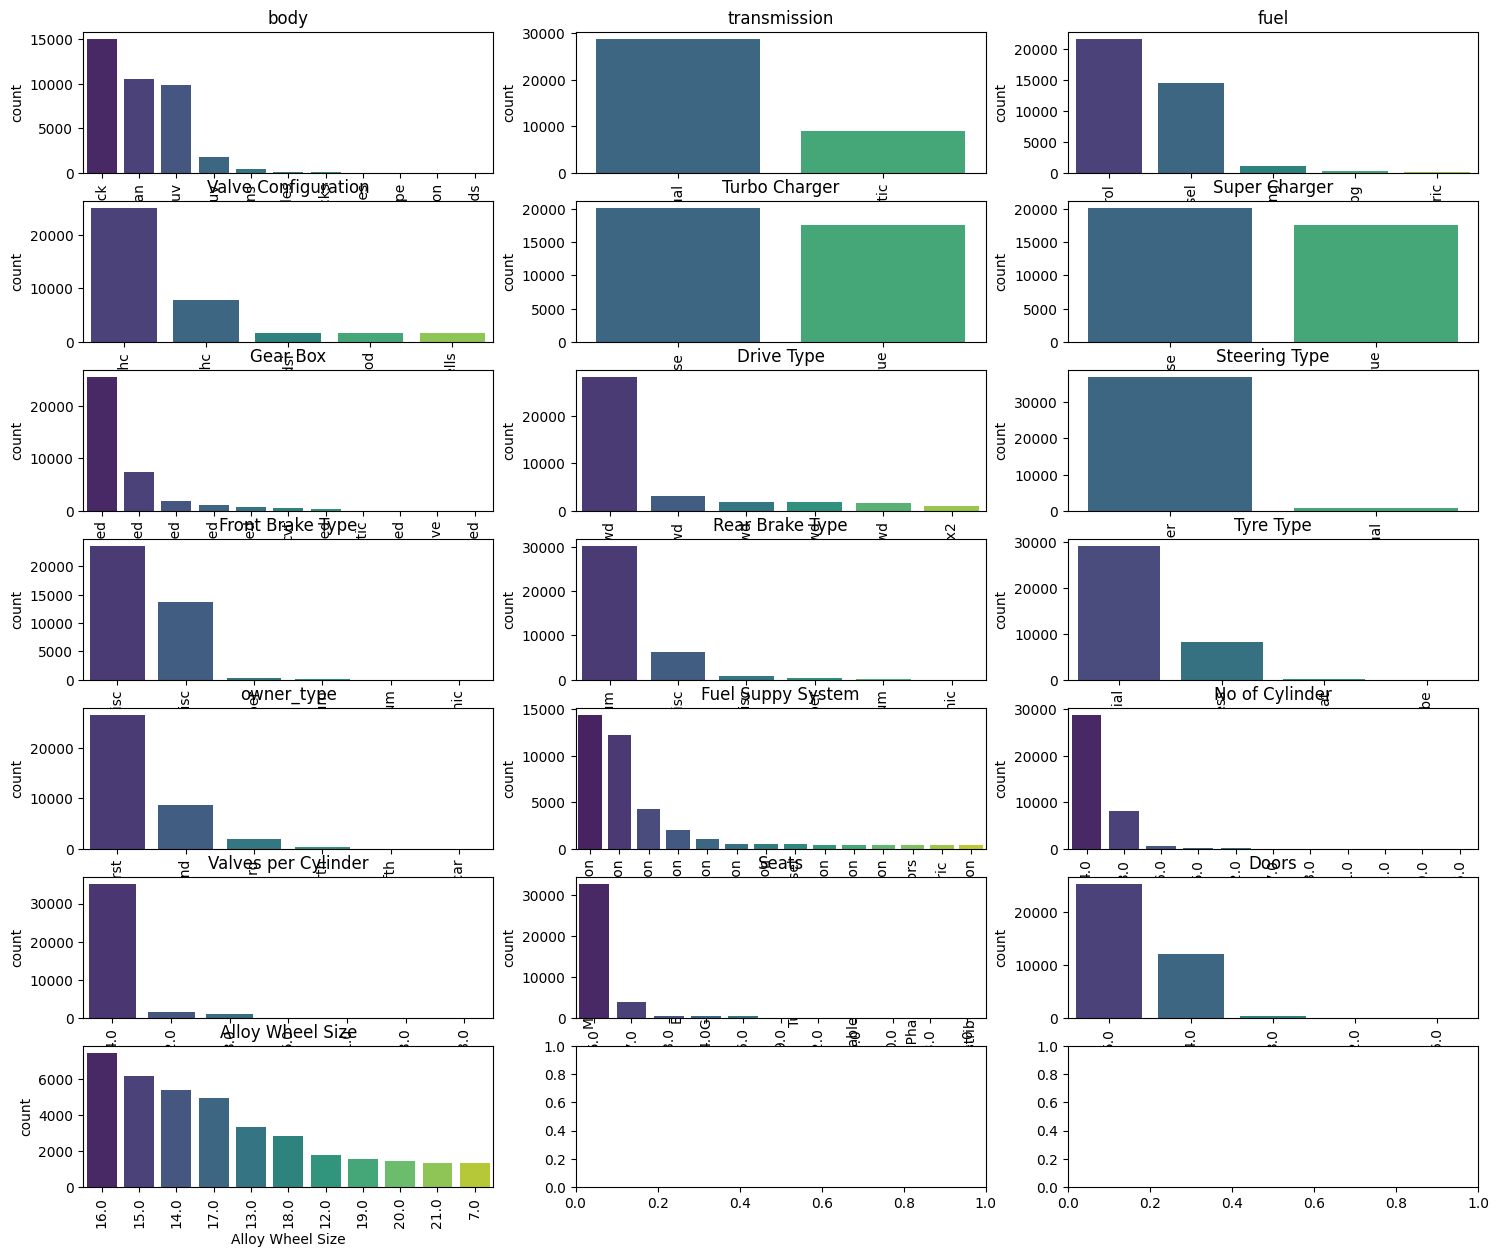

In [88]:
import math

n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index, palette="viridis")
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

There are groups of categorical variables that are rarely observed. These will be discussed later. We will encode the rare ones as "other."

## 3.6. Pair Plots of Numerical Variables

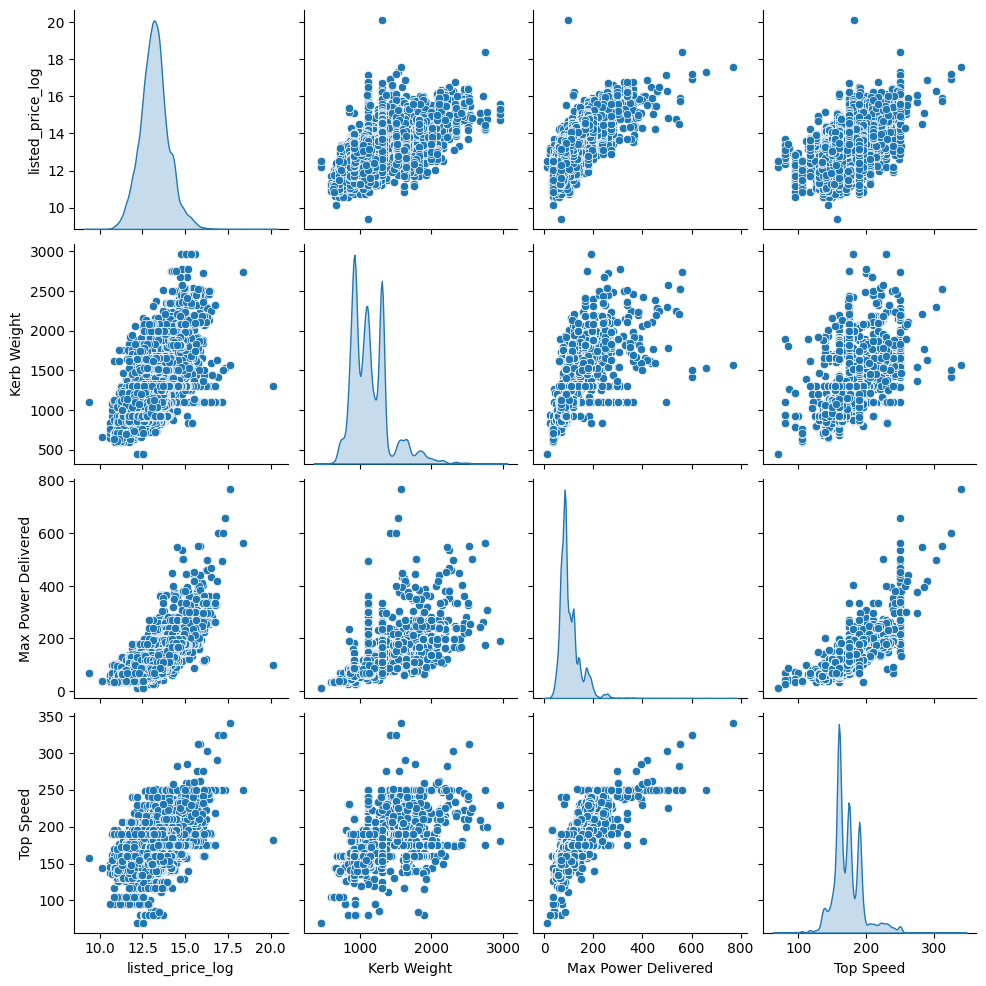

In [93]:
sns.pairplot(df[['listed_price_log', 'Kerb Weight', 'Max Power Delivered', 'Top Speed']], diag_kind='kde')
plt.show()

# 4. Feature Extraction

In [96]:
df.head()

myear       body transmission fuel        km     oem           model  \
0   2016  hatchback       manual  cng  69162.00  maruti  maruti wagon r   
1   2015  hatchback       manual  cng  45864.00  maruti  maruti celerio   
2   2015      sedan       manual  cng  81506.00   honda     honda amaze   
3   2013  hatchback       manual  cng 115893.00  maruti  maruti wagon r   
4   2022        muv       manual  cng  18900.00  maruti   maruti ertiga   

        City  discountValue   Color             Engine Type  No of Cylinder  \
0    lucknow              0  silver             k10b engine            3.00   
1     mumbai              0    grey             k10b engine            3.00   
2  new delhi              0  silver    i-vtec petrol engine            4.00   
3  new delhi              0  silver  k series petrol engine            3.00   
4     mumbai              0   white                    k15c            4.00   

   Valves per Cylinder Valve Configuration  Turbo Charger  Super Charger  \
0                 4.00                dohc          False          False   
1                 4.00                dohc          False          False   
2                 4.00                sohc          False          False   
3                 4.00                dohc          False          False   
4                 4.00       ohv / pushrod           True           True   

   Length   Width  Height  Kerb Weight Gear Box Drive Type  Seats  \
0 3599.00 1495.00 1700.00       960.00  5 speed        fwd   5.00   
1 3600.00 1600.00 1560.00       915.00  5 speed        fwd   5.00   
2 3990.00 1680.00 1505.00       950.00  5 speed        fwd   5.00   
3 3595.00 1475.00 1700.00       960.00  5 speed        fwd   5.00   
4 4395.00 1735.00 1690.00      1250.00  5 speed        2wd   7.00   

  Steering Type Front Brake Type Rear Brake Type  Top Speed  Acceleration  \
0         power  ventilated disc            drum     137.00         15.90   
1         power  ventilated disc            drum     150.00         15.05   
2         power             disc            drum     160.00         15.00   
3         power  ventilated disc            drum     160.00         14.20   
4         power             disc            drum     160.00         13.30   

         Tyre Type  Doors  Cargo Volume owner_type  \
0         tubeless   5.00        180.00      first   
1  tubeless radial   5.00        235.00      first   
2  tubeless radial   4.00        400.00     second   
3  tubeless radial   4.00        350.00     second   
4  tubeless radial   5.00        350.00      first   

                 Fuel Suppy System  Alloy Wheel Size  Max Power Delivered  \
0       Multi-Point Fuel Injection             13.00                58.16   
1          Gasoline Port Injection             17.00                58.20   
2                         Electric             20.00                86.70   
3       Multi-Point Fuel Injection             13.00                58.20   
4  Distributor-Type Fuel Injection             15.00                86.63   

   listed_price_log  
0             12.82  
1             12.81  
2             12.95  
3             12.39  
4             13.98

In [98]:
def feature_extraction(dataframe):
    # car age
    dataframe['car_age'] = dataframe['myear'].max() - dataframe['myear']
    # Let's compare power and weight
    dataframe['power_to_weight'] = dataframe['Max Power Delivered'] / dataframe['Kerb Weight']
    # Vehicle volume
    dataframe['vehicle_volume'] = dataframe['Length'] * dataframe['Width'] * dataframe['Height']
    # Segment fuel combination
    dataframe['segment_fuel'] = dataframe['body'] + "_" + dataframe['fuel']
    # hardware score
    feature_cols = ['Turbo Charger', 'Super Charger', 'Front Brake Type', 
                'Rear Brake Type', 'Steering Type']

    dataframe['feature_count'] = (
        dataframe['Turbo Charger'].astype(int) + 
        dataframe['Super Charger'].astype(int) + 
        dataframe['Steering Type'].eq('power').astype(int) +
        dataframe['Front Brake Type'].eq('disc').astype(int) +
        dataframe['Rear Brake Type'].eq('disc').astype(int)
    )
    # km per year
    dataframe['km_per_year'] = dataframe['km'] / dataframe['car_age']
    # is first owner
    dataframe["is_first_owner"] = (dataframe['owner_type'] == 'first').astype(int)
    # is turbo
    dataframe["is_turbo"] = dataframe['Turbo Charger'].astype(int)
    return dataframe
    

In [100]:
df_new = feature_extraction(df)
df_new.head()

myear       body transmission fuel        km     oem           model  \
0   2016  hatchback       manual  cng  69162.00  maruti  maruti wagon r   
1   2015  hatchback       manual  cng  45864.00  maruti  maruti celerio   
2   2015      sedan       manual  cng  81506.00   honda     honda amaze   
3   2013  hatchback       manual  cng 115893.00  maruti  maruti wagon r   
4   2022        muv       manual  cng  18900.00  maruti   maruti ertiga   

        City  discountValue   Color             Engine Type  No of Cylinder  \
0    lucknow              0  silver             k10b engine            3.00   
1     mumbai              0    grey             k10b engine            3.00   
2  new delhi              0  silver    i-vtec petrol engine            4.00   
3  new delhi              0  silver  k series petrol engine            3.00   
4     mumbai              0   white                    k15c            4.00   

   Valves per Cylinder Valve Configuration  Turbo Charger  Super Charger  \
0                 4.00                dohc          False          False   
1                 4.00                dohc          False          False   
2                 4.00                sohc          False          False   
3                 4.00                dohc          False          False   
4                 4.00       ohv / pushrod           True           True   

   Length   Width  Height  Kerb Weight Gear Box Drive Type  Seats  \
0 3599.00 1495.00 1700.00       960.00  5 speed        fwd   5.00   
1 3600.00 1600.00 1560.00       915.00  5 speed        fwd   5.00   
2 3990.00 1680.00 1505.00       950.00  5 speed        fwd   5.00   
3 3595.00 1475.00 1700.00       960.00  5 speed        fwd   5.00   
4 4395.00 1735.00 1690.00      1250.00  5 speed        2wd   7.00   

  Steering Type Front Brake Type Rear Brake Type  Top Speed  Acceleration  \
0         power  ventilated disc            drum     137.00         15.90   
1         power  ventilated disc            drum     150.00         15.05   
2         power             disc            drum     160.00         15.00   
3         power  ventilated disc            drum     160.00         14.20   
4         power             disc            drum     160.00         13.30   

         Tyre Type  Doors  Cargo Volume owner_type  \
0         tubeless   5.00        180.00      first   
1  tubeless radial   5.00        235.00      first   
2  tubeless radial   4.00        400.00     second   
3  tubeless radial   4.00        350.00     second   
4  tubeless radial   5.00        350.00      first   

                 Fuel Suppy System  Alloy Wheel Size  Max Power Delivered  \
0       Multi-Point Fuel Injection             13.00                58.16   
1          Gasoline Port Injection             17.00                58.20   
2                         Electric             20.00                86.70   
3       Multi-Point Fuel Injection             13.00                58.20   
4  Distributor-Type Fuel Injection             15.00                86.63   

   listed_price_log  car_age  power_to_weight  vehicle_volume   segment_fuel  \
0             12.82        7             0.06   9146858500.00  hatchback_cng   
1             12.81        8             0.06   8985600000.00  hatchback_cng   
2             12.95        8             0.09  10088316000.00      sedan_cng   
3             12.39       10             0.06   9014462500.00  hatchback_cng   
4             13.98        1             0.07  12886799250.00        muv_cng   

   feature_count  km_per_year  is_first_owner  is_turbo  
0              1      9880.29               1         0  
1              1      5733.00               1         0  
2              2     10188.25               0         0  
3              1     11589.30               0         0  
4              4     18900.00               1         1

Let's check the inf value:

In [103]:
for i in df_new.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Number of inf values in variable {i}: {np.isinf(df_new[i].values).sum()}")

Number of inf values in variable myear: 0
Number of inf values in variable km: 0
Number of inf values in variable discountValue: 0
Number of inf values in variable No of Cylinder: 0
Number of inf values in variable Valves per Cylinder: 0
Number of inf values in variable Length: 0
Number of inf values in variable Width: 0
Number of inf values in variable Height: 0
Number of inf values in variable Kerb Weight: 0
Number of inf values in variable Seats: 0
Number of inf values in variable Top Speed: 0
Number of inf values in variable Acceleration: 0
Number of inf values in variable Doors: 0
Number of inf values in variable Cargo Volume: 0
Number of inf values in variable Alloy Wheel Size: 0
Number of inf values in variable Max Power Delivered: 0
Number of inf values in variable listed_price_log: 0
Number of inf values in variable car_age: 0
Number of inf values in variable power_to_weight: 0
Number of inf values in variable vehicle_volume: 0
Number of inf values in variable km_per_year: 35


In [105]:
df_new["km_per_year"] = df_new["km_per_year"].replace([np.inf, -np.inf], np.nan)

In [107]:
df_new["km_per_year"] = df_new["km_per_year"].fillna(df_new["km_per_year"].median())

In [109]:
df_new.isnull().sum()

myear                  0
body                   0
transmission           0
fuel                   0
km                     0
oem                    0
model                  0
City                   0
discountValue          0
Color                  0
Engine Type            0
No of Cylinder         0
Valves per Cylinder    0
Valve Configuration    0
Turbo Charger          0
Super Charger          0
Length                 0
Width                  0
Height                 0
Kerb Weight            0
Gear Box               0
Drive Type             0
Seats                  0
Steering Type          0
Front Brake Type       0
Rear Brake Type        0
Top Speed              0
Acceleration           0
Tyre Type              0
Doors                  0
Cargo Volume           0
owner_type             0
Fuel Suppy System      0
Alloy Wheel Size       0
Max Power Delivered    0
listed_price_log       0
car_age                0
power_to_weight        0
vehicle_volume         0
segment_fuel           0


Let's examine the effect of the newly created variables on the target variable:

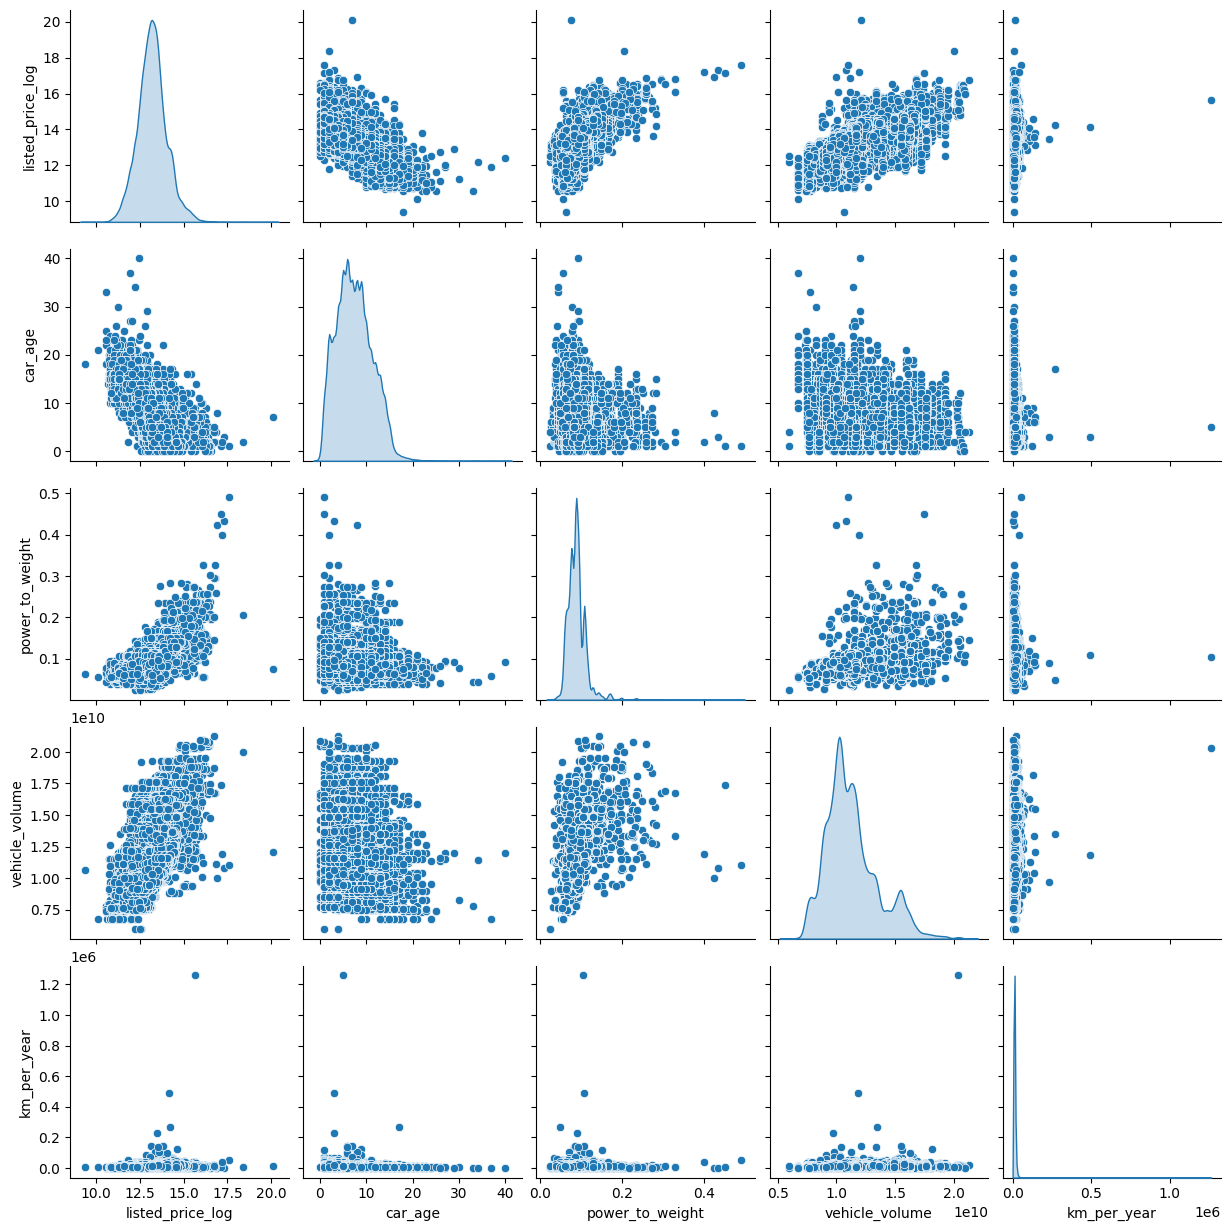

In [111]:
sns.pairplot(df_new[['listed_price_log', 'car_age', 'power_to_weight', 'vehicle_volume', 'km_per_year']], diag_kind='kde')
plt.show()

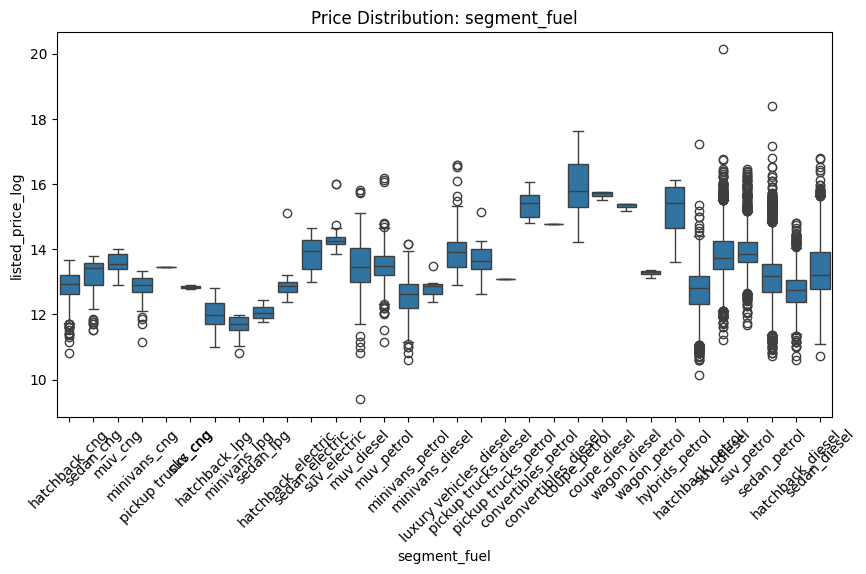

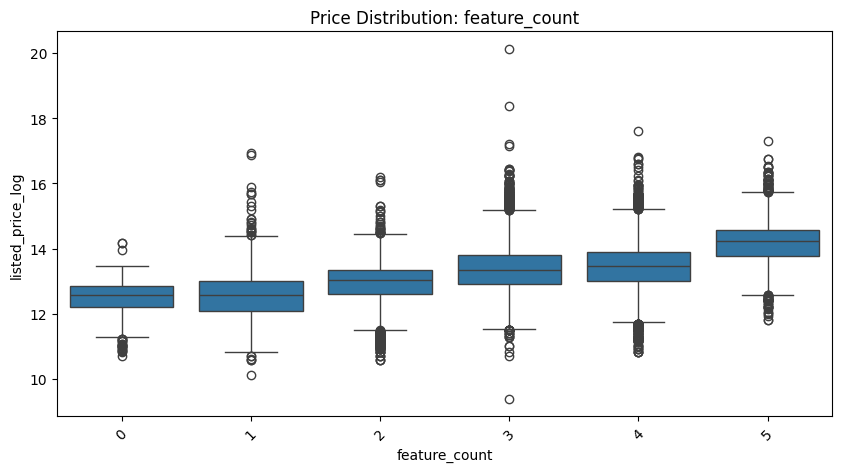

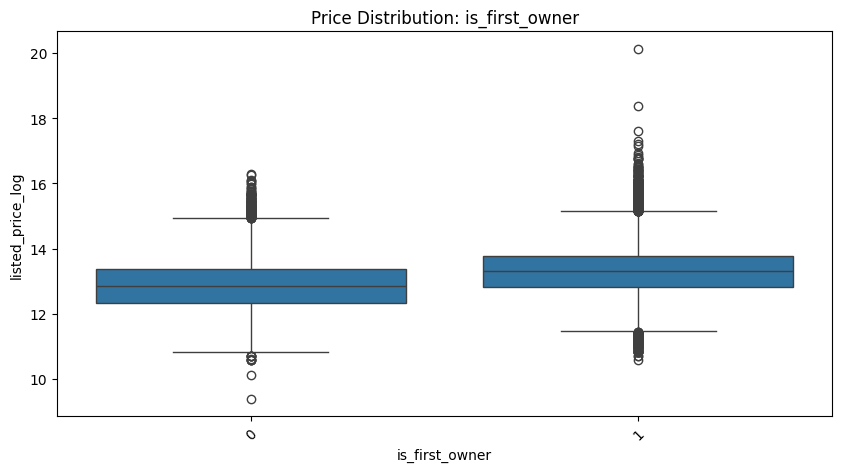

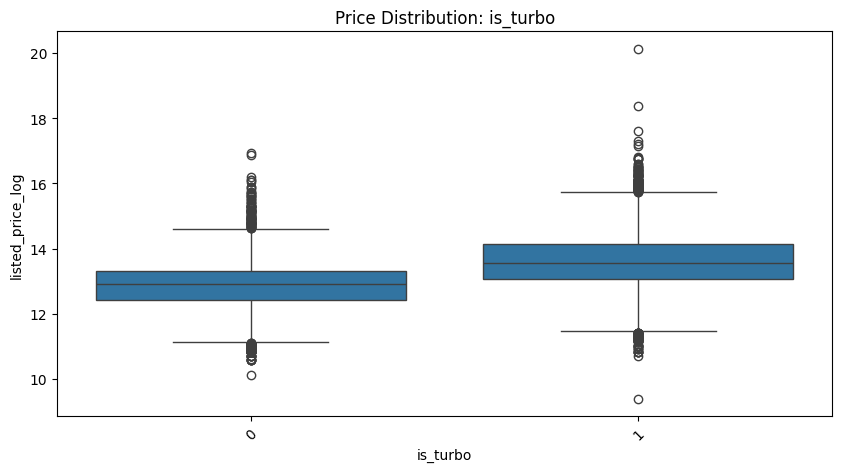

In [113]:
for col in ["segment_fuel","feature_count","is_first_owner","is_turbo"]:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df_new, x=col, y="listed_price_log")
    plt.title(f'Price Distribution: {col}')
    plt.xticks(rotation=45)
    plt.show()

In [115]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_new)

Observations: 37744
Variables: 44
cat_cols_count: 22
num_cols_count: 16
cat_but_car_count: 6
num_but_cat_count: 8


# 5. Outlier Analysis

Let's remove the outliers in the most extreme regions from the data set:

In [118]:
def remove_outliers_from_all_columns(df, numeric_cols, threshold = 1.5, qr1=0.01, qr2=0.99):
    df_clean = df.copy()
    for col in numeric_cols:
        Q1 = df[col].quantile(qr1)
        Q3 = df[col].quantile(qr2)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col]<=upper_bound)]
    return df_clean.copy()

In [120]:
print("original data shape: ", df_new.shape)
df_new_clean = remove_outliers_from_all_columns(df, num_cols)
print("all columns cleaning shape: ", df_new_clean.shape)

original data shape:  (37744, 44)
all columns cleaning shape:  (37634, 44)


# 6. Data Preprocessing

Let's make Rare Encoder.

In [122]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(f"\n--- {col} ---")
        
        print(pd.DataFrame({
            "COUNT": dataframe[col].value_counts(),
            "RATIO": dataframe[col].value_counts()/len(dataframe),
            "TARGET_MEAN": dataframe.groupby(col)[target].mean()
        }))
        
rare_analyser(df_new, "listed_price_log", cat_cols)


--- body ---
                 COUNT  RATIO  TARGET_MEAN
body                                      
convertibles        22   0.00        15.35
coupe               20   0.00        15.86
hatchback        15061   0.40        12.71
hybrids              4   0.00        15.14
luxury vehicles     71   0.00        14.04
minivans           391   0.01        12.57
muv               1814   0.05        13.48
pickup trucks       47   0.00        13.64
sedan            10516   0.28        13.24
suv               9791   0.26        13.85
wagon                7   0.00        14.15

--- transmission ---
              COUNT  RATIO  TARGET_MEAN
transmission                           
automatic      8873   0.24        13.97
manual        28871   0.76        12.96

--- fuel ---
          COUNT  RATIO  TARGET_MEAN
fuel                               
cng        1076   0.03        12.92
diesel    14591   0.39        13.48
electric    130   0.00        14.02
lpg         205   0.01        11.99
petrol    21742

In [124]:
def rare_encoder(dataframe, rare_prec, cat_cols):
    for col in cat_cols:
        data = pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                             "RATIO": dataframe[col].value_counts()/len(dataframe)})
        rare_labels = data[data["RATIO"] <= rare_prec].index
        most_common_label = data["RATIO"].idxmax()
        dataframe[col] = dataframe[col].replace(rare_labels, most_common_label)
    return dataframe

df_new = rare_encoder(df_new, 0.01, cat_cols)

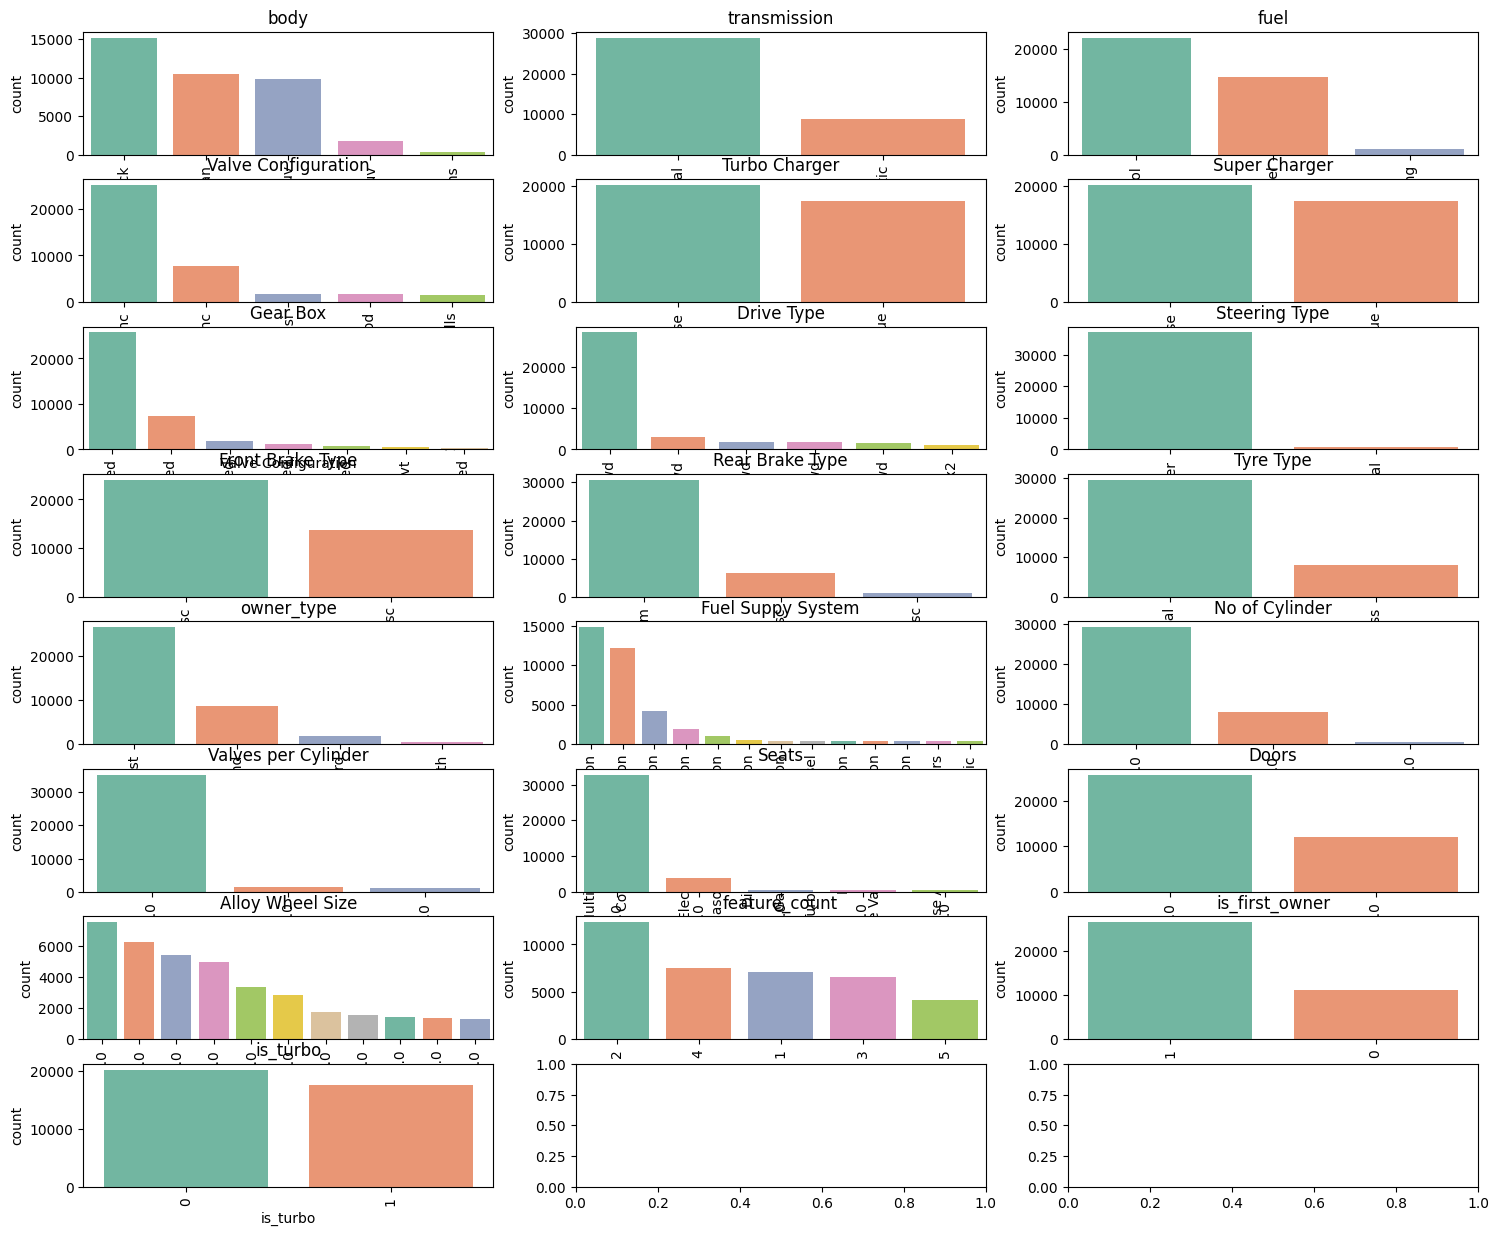

In [126]:
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df_new, x=col, ax=axes[i], order=df_new[col].value_counts().index, palette="Set2")
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

In [128]:
## Train_test_split

X = df_new.drop("listed_price_log", axis=1)
y = df_new["listed_price_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=15)

In [130]:
label_encoder_cols = []
no_encoder_cols = []
onehot_columns = []

for i in X_train[cat_cols].columns:
    if X_train[i].nunique() > 4:
        label_encoder_cols.append(i)
    else:
        onehot_columns.append(i)

In [132]:
encoders = {}
for col in label_encoder_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    encoders[col] = LabelEncoder()
    X_train[col] = encoders[col].fit_transform(X_train[col])
    X_test[col] = encoders[col].transform(X_test[col])

In [134]:
freq_encoders = {}

for col in cat_but_car:
    freq = X_train[col].value_counts(normalize=True)
    freq_encoders[col] = freq.to_dict()  # sözlük haline getir
    
    X_train[col + "_freq"] = X_train[col].map(freq)
    X_test[col + "_freq"] = X_test[col].map(freq)
    X_test[col + "_freq"] = X_test[col + "_freq"].fillna(freq.mean())

X_train = X_train.drop(cat_but_car, axis=1)
X_test = X_test.drop(cat_but_car, axis=1)

In [136]:
cat_cols, num_cols, cat_but_car = grab_col_names(X_train)

Observations: 26420
Variables: 43
cat_cols_count: 21
num_cols_count: 22
cat_but_car_count: 0
num_but_cat_count: 12


In [138]:
X_train.head()

myear  body transmission    fuel        km  discountValue  \
26301   2016     4    automatic  diesel  66968.00              0   
7204    2012     3       manual  diesel 110112.00              0   
27469   2010     0       manual  petrol  52155.00              0   
9799    2020     4    automatic  petrol  22304.00              0   
241     2015     0       manual     cng  60000.00              0   

       No of Cylinder  Valves per Cylinder  Valve Configuration  \
26301            4.00                 4.00                    1   
7204             4.00                 4.00                    1   
27469            3.00                 4.00                    0   
9799             3.00                 4.00                    2   
241              3.00                 4.00                    1   

       Turbo Charger  Super Charger  Length   Width  Height  Kerb Weight  \
26301           True           True 4585.00 1890.00 1785.00      1305.00   
7204            True           True 4386.00 1699.00 1466.00      1205.00   
27469          False          False 3595.00 1475.00 1700.00       870.00   
9799            True           True 3995.00 1790.00 1642.00      1305.00   
241            False          False 3599.00 1495.00 1700.00       960.00   

       Gear Box  Drive Type  Seats Steering Type Front Brake Type  \
26301         2           4      3         power             disc   
7204          1           4      1         power             disc   
27469         1           4      1         power  ventilated disc   
9799          3           4      1         power             disc   
241           1           4      1         power  ventilated disc   

      Rear Brake Type  Top Speed  Acceleration        Tyre Type  Doors  \
26301            disc     185.00         10.00         tubeless   5.00   
7204             drum     190.00         11.20  tubeless radial   4.00   
27469            drum     160.00         14.20  tubeless radial   4.00   
9799             drum     175.00         12.36  tubeless radial   5.00   
241              drum     137.00         15.90         tubeless   5.00   

       Cargo Volume owner_type  Fuel Suppy System  Alloy Wheel Size  \
26301        720.00      first                  2                 5   
7204         460.00     second                  2                 2   
27469        350.00     second                  9                 1   
9799         392.00      first                  5                 4   
241          180.00     second                 12                 4   

       Max Power Delivered  car_age  power_to_weight  vehicle_volume  \
26301               140.00        7             0.11  15468185250.00   
7204                103.50       11             0.09  10924359324.00   
27469                67.10       13             0.08   9014462500.00   
9799                118.36        3             0.09  11742024100.00   
241                  58.16        8             0.06   9146858500.00   

       feature_count  km_per_year  is_first_owner  is_turbo  oem_freq  \
26301              4      9566.86               1         1      0.06   
7204               3     10010.18               0         1      0.03   
27469              0      4011.92               0         0      0.26   
9799               3      7434.67               1         1      0.02   
241                0      7500.00               0         0      0.26   

       model_freq  City_freq  Color_freq  Engine Type_freq  segment_fuel_freq  
26301        0.02       0.13        0.12              0.02               0.17  
7204         0.01       0.13        0.27              0.01               0.12  
27469        0.04       0.13        0.01              0.03               0.31  
9799         0.01       0.13        0.00              0.00               0.09  
241          0.04       0.00        0.12              0.02               0.02

In [146]:
new_cols = [col for col in X_train.columns.tolist() if "_freq" in col]
scaler_cols = num_cols + label_encoder_cols+new_cols

scalers = {}
for col in scaler_cols:
    scalers[col] = StandardScaler()
    X_train[[col]] = scalers[col].fit_transform(X_train[[col]])
    X_test[[col]] = scalers[col].transform(X_test[[col]])

In [150]:
transformer = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore", dtype=np.float64), onehot_columns)
    ],
    remainder="passthrough"
)

In [152]:
transformer.fit(X_train)

X_train_encoded = pd.DataFrame(transformer.transform(X_train), columns=transformer.get_feature_names_out(X_train.columns))
X_test_encoded = pd.DataFrame(transformer.transform(X_test), columns=transformer.get_feature_names_out(X_train.columns))

# 7. Model Building

In [156]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_sqare = r2_score(true, predicted)
    return mae, rmse, r2_sqare

In [158]:
models = {
    "Random Forest Regressor": RandomForestRegressor(),
    "Adaboost Regressor": AdaBoostRegressor(),
    "Gradient Boost Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor()
}

In [162]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_encoded, y_train)

    y_train_pred = model.predict(X_train_encoded)
    y_test_pred = model.predict(X_test_encoded)

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    print("Model performance for Training Set")
    print("Root Mean Squared Error: ", model_train_rmse)
    print("Mean Absolute Error: ", model_train_mae)
    print("R2 Score: ", model_train_r2)

    print("---------------------------------")

    print("Model performance for Test Set")
    print("Root Mean Squared Error: ", model_test_rmse)
    print("Mean Absolute Error: ", model_test_mae)
    print("R2 Score: ", model_test_r2)

    print("-------------------------------")
    print("\n")

Random Forest Regressor
Model performance for Training Set
Root Mean Squared Error:  0.07312318535183326
Mean Absolute Error:  0.05027403684063754
R2 Score:  0.9920757549716797
---------------------------------
Model performance for Test Set
Root Mean Squared Error:  0.19447904206723604
Mean Absolute Error:  0.13541094583293828
R2 Score:  0.9441776965218097
-------------------------------


Adaboost Regressor
Model performance for Training Set
Root Mean Squared Error:  0.33984258386284155
Mean Absolute Error:  0.25932770288303486
R2 Score:  0.8288396023016622
---------------------------------
Model performance for Test Set
Root Mean Squared Error:  0.3445358679714967
Mean Absolute Error:  0.2613068077386106
R2 Score:  0.8248012424635534
-------------------------------


Gradient Boost Regressor
Model performance for Training Set
Root Mean Squared Error:  0.20598086219751
Mean Absolute Error:  0.14957213403987188
R2 Score:  0.9371216066581709
---------------------------------
Model perf

# 8. Model Tuning

In [167]:
xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [5,8,12,20,30],
    "n_estimators": [100, 200, 300, 500],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7, 1]
}

randomized_cv=RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=xgboost_params, cv=5, n_jobs=-1)

randomized_cv.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.7,
                                                             1],
                                        'learning_rate': [0.1, 0.01],
                                        'max_depth': [5, 8, 12, 20, 30],
                                        'n_estimators': [100, 200, 300, 500]})

In [169]:
randomized_cv.best_params_

{'n_estimators': 500,
 'max_depth': 8,
 'learning_rate': 0.1,
 'colsample_bytree': 0.4}

In [171]:
model = XGBRegressor(**randomized_cv.best_params_)
model.fit(X_train_encoded, y_train)

y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)
model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
print(list(models.keys())[i])
print("Model performance for Training Set")
print("Root Mean Squared Error: ", model_train_rmse)
print("Mean Absolute Error: ", model_train_mae)
print("R2 Score: ", model_train_r2)
print("---------------------------------")
print("Model performance for Test Set")
print("Root Mean Squared Error: ", model_test_rmse)
print("Mean Absolute Error: ", model_test_mae)
print("R2 Score: ", model_test_r2)
print("-------------------------------")
print("\n")

XGBoost Regressor
Model performance for Training Set
Root Mean Squared Error:  0.06831816310198087
Mean Absolute Error:  0.04934670017324887
R2 Score:  0.9930829637075621
---------------------------------
Model performance for Test Set
Root Mean Squared Error:  0.1727940709973741
Mean Absolute Error:  0.11792652891356217
R2 Score:  0.9559323579172451
-------------------------------




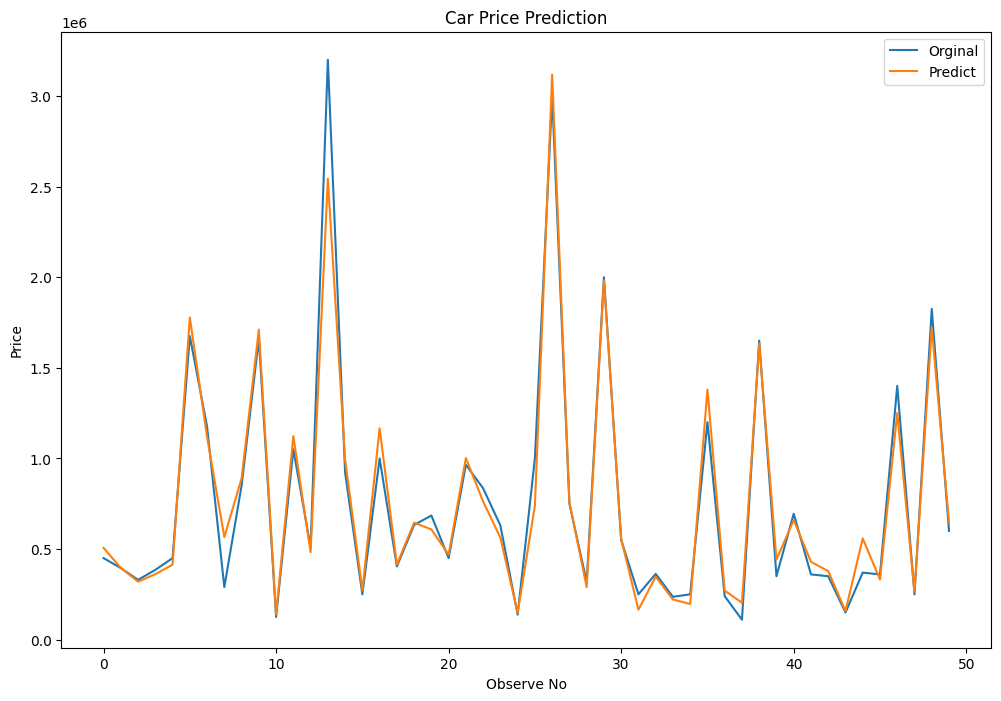

In [173]:
plt.figure(figsize=(12,8))
plt.plot(range(len(y_test[:50])),np.expm1(y_test[:50]),label="Orginal")
plt.plot(range(len(y_test[:50])),np.expm1(y_test_pred[:50]),label="Predict")
plt.title("Car Price Prediction")
plt.ylabel("Price")
plt.xlabel("Observe No")
plt.legend()
plt.show()

# 9. Effects of Variables in the Model on the Target Variable

In [175]:
import shap

100%|===================| 11314/11324 [12:35<00:00]        

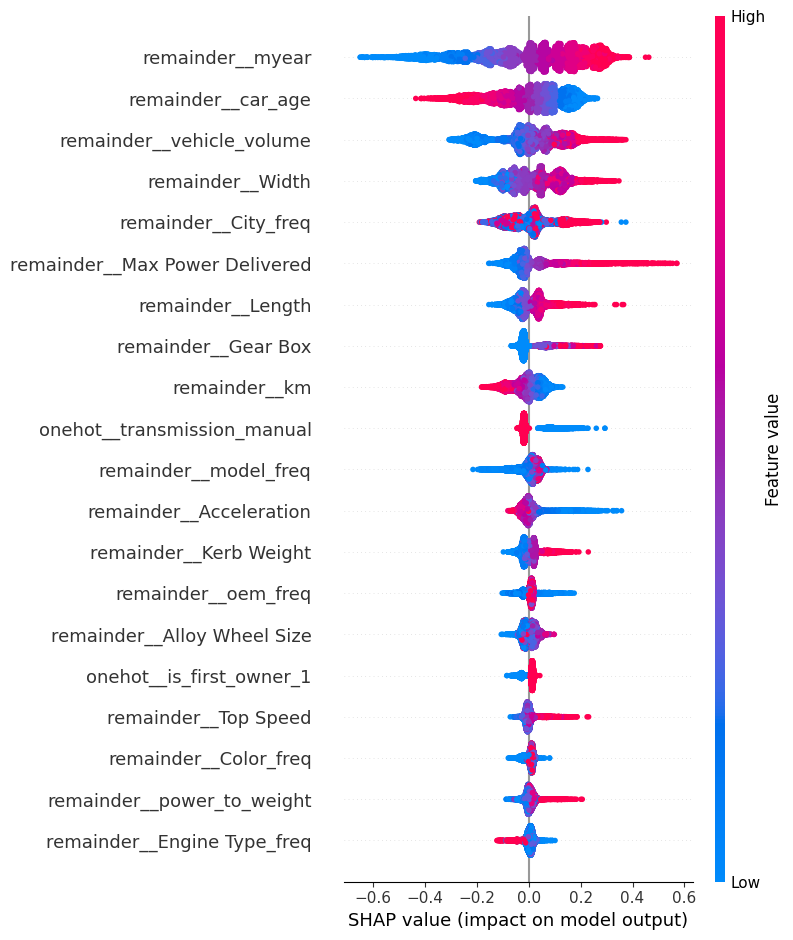

In [177]:
explainer = shap.TreeExplainer(model, X_train_encoded)
shap_values = explainer.shap_values(X_test_encoded)

shap.summary_plot(shap_values, X_test_encoded)

* We see that new vehicles increase the price while old vehicles decrease the price. The variable myear is the most dominant factor in the model's estimation.
* As a vehicle ages, its value decreases.
* Larger vehicles (SUV, sedan, etc.) are generally associated with higher prices. (vehicle volume)
* remainder _City_freq, remainder __model_freq, remainder _oem_freq are the most frequently observed variables that can increase the price.
* remainder__km, higher mileage reduces price.
* The model uses usage-related features such as age, model year, and mileage very strongly when predicting price.
* Technical/performance features (power, top speed, kerb weight) come second.
* Categorical frequency variables are in third place (weaker but significant contribution).
* myear and car_age are likely highly correlated. One of them can be removed from the dataset.
* Colors are mixed together in the city_freq, color_freq, and oem_freq variables. These variables may contain noise and can be removed from the dataset.

In [189]:
feature_effect = pd.DataFrame({
    "Feature": X_train_encoded.columns,
    "Mean_Abs_SHAP": np.abs(shap_values).mean(axis=0),
    "Mean_SHAP": shap_values.mean(axis=0)
}).sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

feature_effect.head(20)

Feature  Mean_Abs_SHAP  Mean_SHAP
0                 remainder__myear           0.17       0.01
1               remainder__car_age           0.11       0.01
2        remainder__vehicle_volume           0.09       0.01
3                 remainder__Width           0.08       0.02
4             remainder__City_freq           0.07       0.00
5   remainder__Max Power Delivered           0.07       0.02
6                remainder__Length           0.05       0.00
7              remainder__Gear Box           0.04       0.01
8                    remainder__km           0.04      -0.00
9      onehot__transmission_manual           0.04       0.01
10           remainder__model_freq           0.03       0.00
11         remainder__Acceleration           0.03       0.01
12          remainder__Kerb Weight           0.03       0.01
13             remainder__oem_freq           0.02       0.00
14     remainder__Alloy Wheel Size           0.02       0.00
15        onehot__is_first_owner_1           0.02       0.00
16            remainder__Top Speed           0.01       0.00
17           remainder__Color_freq           0.01       0.00
18      remainder__power_to_weight           0.01       0.00
19     remainder__Engine Type_freq           0.01       0.00

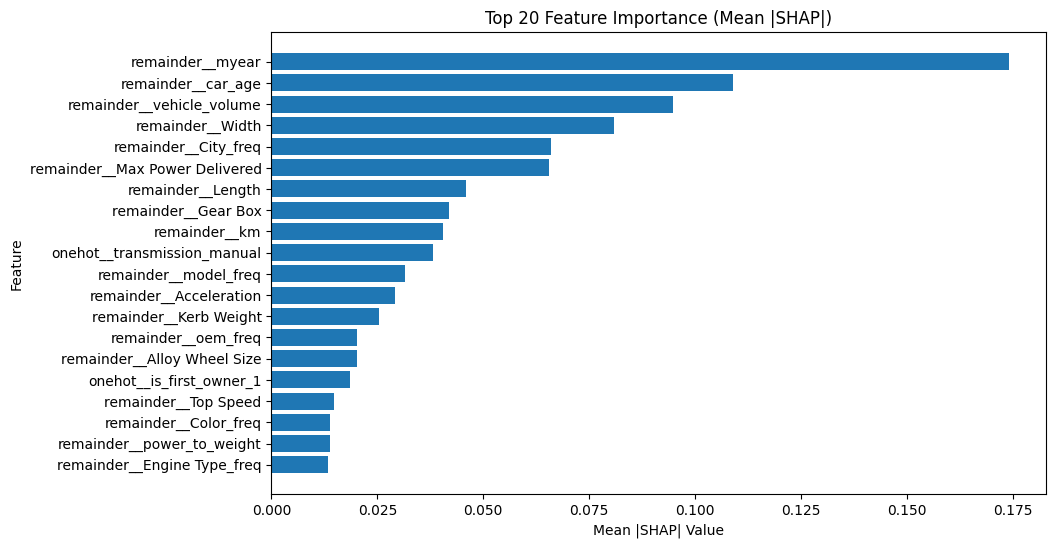

In [191]:
plt.figure(figsize=(10,6))
plt.barh(feature_effect["Feature"][:20][::-1],
         feature_effect["Mean_Abs_SHAP"][:20][::-1])
plt.title("Top 20 Feature Importance (Mean |SHAP|)")
plt.xlabel("Mean |SHAP| Value")
plt.ylabel("Feature")
plt.show()

In [196]:
drop_cols = ["remainder__car_age", "remainder__City_freq", "remainder__oem_freq", "remainder__oem_freq"]
X_train_new = X_train_encoded.drop(drop_cols,axis=1)
X_test_new = X_test_encoded.drop(drop_cols,axis=1)

model_2 = XGBRegressor(**randomized_cv.best_params_)
model_2.fit(X_train_new, y_train)

y_train_pred_2 = model_2.predict(X_train_new)
y_test_pred_2 = model_2.predict(X_test_new)
model_train_mae_2, model_train_rmse_2, model_train_r2_2 = evaluate_model(y_train, y_train_pred_2)
model_test_mae_2, model_test_rmse_2, model_test_r2_2 = evaluate_model(y_test, y_test_pred_2)
print("Model performance for Training Set")
print("Root Mean Squared Error: ", model_train_rmse_2)
print("Mean Absolute Error: ", model_train_mae_2)
print("R2 Score: ", model_train_r2_2)
print("---------------------------------")
print("Model performance for Test Set")
print("Root Mean Squared Error: ", model_test_rmse_2)
print("Mean Absolute Error: ", model_test_mae_2)
print("R2 Score: ", model_test_r2_2)
print("-------------------------------")
print("\n")

Model performance for Training Set
Root Mean Squared Error:  0.09289841379289612
Mean Absolute Error:  0.06713926511803699
R2 Score:  0.9872101841921666
---------------------------------
Model performance for Test Set
Root Mean Squared Error:  0.20059560782827612
Mean Absolute Error:  0.14444020880470176
R2 Score:  0.9406111412944245
-------------------------------


